# Import libraries and set configs

In [1]:
import sys
sys.path.append('..')

import os
import json
import joblib
import random
import warnings
from collections import defaultdict
import numpy as np
import pandas as pd
from glob import glob
from optimizer.optimizer import Optimizer
from os import environ
from datetime import timedelta
from tqdm.auto import tqdm
from datetime import datetime

from eli5.sklearn import PermutationImportance

import optuna
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, precision_score

import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Style, Fore

# Set environment variable
environ["ENV"] = "optimize"

from config.config import ConfigFactory
from indicators import indicators

from api.tvdatafeed.main import TvDatafeed, Interval
from constants.constants import tv_username, tv_password


class CFG:
    load = False
    historical = False
    create_dataset = False
    cls_target_ratio_tp = 1.03
    cls_target_ratio_sl = 1.03
    ttype = 'both'
    patterns_to_filter = ['STOCH_RSI_Volume24']
    select_features = False
    optimize = False
    n_repeats = 1
    n_folds = 8
    agg_periods = [24, 168, 720]
    agg_funcs = [np.min, np.max, np.mean, np.median, np.std]

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

tqdm.pandas()

warnings.simplefilter(action='ignore', category=(FutureWarning, pd.errors.PerformanceWarning))

# Load data

### Load STOCH_RSI buy data

In [2]:
work_timeframe = '1h'
higher_timeframe = '4h'
opt_limit = 100000

ttype = 'buy'
pattern = ['STOCH', 'RSI', 'Volume24']
indicator_list = pattern
indicator_list_higher = ['Trend', 'MACD']

# Get configs
configs = ConfigFactory.factory(environ).configs
configs['Indicator_list'] = indicator_list
configs['Higher_TF_indicator_list'] = indicator_list_higher
configs['Timeframes']['work_timeframe'] = work_timeframe
configs['Timeframes']['higher_timeframe'] = higher_timeframe

optim_dict = {
                'RSI': {
                        'timeperiod': [14], 
                        'low_bound': [35]
                       },
                'STOCH': {
                          'fastk_period': [9],
                          'slowk_period': [7],
                          'slowd_period': [3], 
                          'low_bound': [25]
                        }
             }

if CFG.load:
  print(f'Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}')
  opt = Optimizer(pattern, optim_dict, clean=True, **configs)
  min_time = datetime.now().replace(microsecond=0, second=0, minute=0) - pd.to_timedelta(365 * 10, unit='D')
  stat = opt.optimize(pattern, ttype, opt_limit, load=True, op_type='ml', historical=CFG.historical, min_time=min_time)
  display(stat) # 31060

### Load STOCH_RSI sell data

In [3]:
work_timeframe = '1h'
higher_timeframe = '4h'
opt_limit = 100000

ttype = 'sell'
pattern = ['STOCH', 'RSI', 'Volume24']
indicator_list = pattern
indicator_list_higher = ['Trend', 'MACD']

# Get configs
configs = ConfigFactory.factory(environ).configs
configs['Indicator_list'] = indicator_list
configs['Higher_TF_indicator_list'] = indicator_list_higher
configs['Timeframes']['work_timeframe'] = work_timeframe
configs['Timeframes']['higher_timeframe'] = higher_timeframe

optim_dict = {
                'RSI': {
                        'timeperiod': [14], 
                        'low_bound': [35]
                       },
                'STOCH': {
                          'fastk_period': [9],
                          'slowk_period': [7],
                          'slowd_period': [3], 
                          'low_bound': [25]
                        }
             }

if CFG.load:
  print(f'Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}')
  opt = Optimizer(pattern, optim_dict, clean=False, **configs)
  min_time = datetime.now().replace(microsecond=0, second=0, minute=0) - pd.to_timedelta(365 * 10, unit='D')
  stat = opt.optimize(pattern, ttype, opt_limit, load=False, op_type='ml', historical=CFG.historical, min_time=min_time)
  display(stat) # 23629

# Test loaded data

### Remove dataframe files with the biggest number of missing data

In [4]:
counter = 0 

tickers_1h = glob('../optimizer/ticker_dataframes/*_1h.pkl')
for ticker in tqdm(tickers_1h[3:]):
    df = pd.read_pickle(ticker)
    nunique = df['time'].diff()[1:].nunique()
    if nunique > 1:
        count = df[df['time'].diff().astype('timedelta64[h]') != 1].shape[0]
        if count > 200:
            print(ticker, nunique, count)
            os.remove(ticker)
            os.remove(ticker[:-6] + '4h.pkl')
            
counter

  0%|          | 0/2207 [00:00<?, ?it/s]

0

### Plot time vs index for some of dataframe files

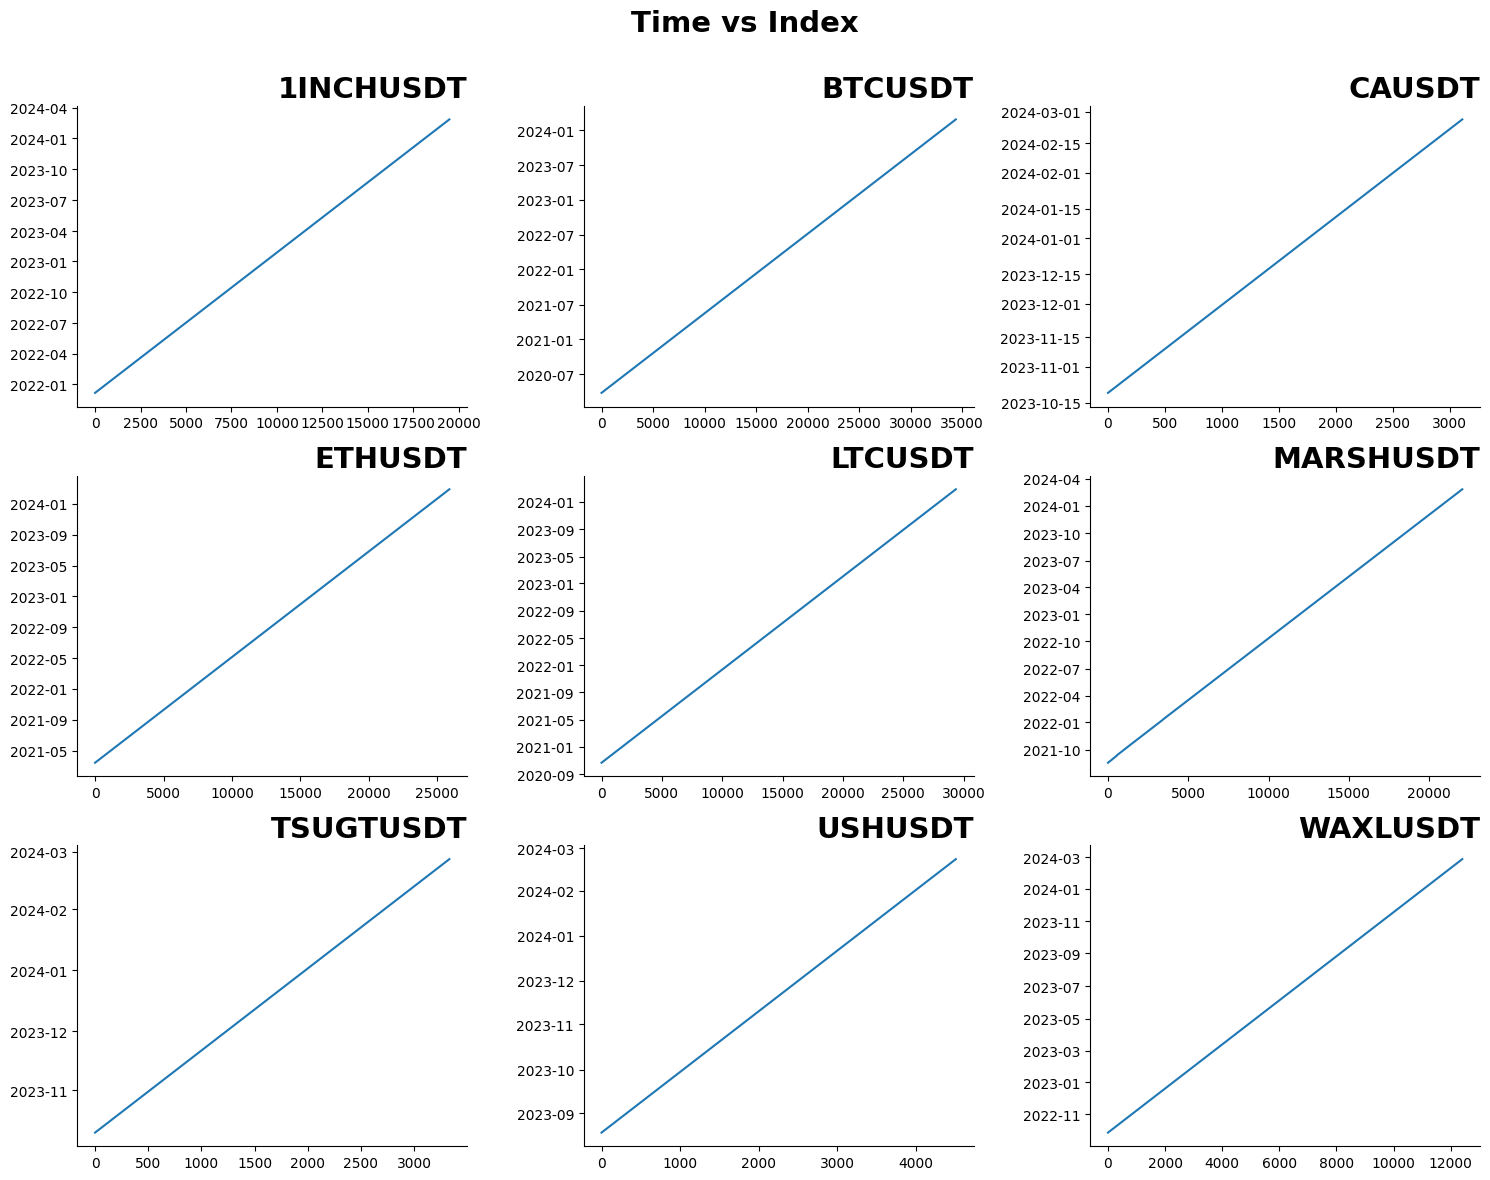

In [5]:
%matplotlib inline

n_cols = 3
n_rows = 3
figsize = (15, 4 * n_rows)

tickers = glob('../optimizer/ticker_dataframes/*_1h.pkl')
random_tickers = random.choices(tickers, k=n_cols*n_rows)
random_tickers[:3] = [t for t in tickers if '/BTCUSDT_1h' in t or '/ETHUSDT_1h' in t or '/LTCUSDT_1h' in t]

def plot_times(random_tickers, n_rows, n_cols):
    fig = plt.figure(figsize=figsize)
    
    for idx in range(n_cols*n_rows):
        ax = plt.subplot(n_rows, n_cols, idx + 1)
        
        df = pd.read_pickle(random_tickers[idx])
        sns.lineplot(data=df['time'])

        ax.set_ylabel(''); ax.spines['top'].set_visible(False), 
        ax.set_xlabel(''); ax.spines['right'].set_visible(False)
        ax.set_title(f'{random_tickers[idx].split("/")[-1][:-7]}', loc='right', weight='bold', fontsize=21)

    
    fig.suptitle(f'Time vs Index\n', ha='center',  fontweight='bold', fontsize=21)
    # fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
    plt.tight_layout()
    plt.show()
    
plot_times(sorted(random_tickers),  n_rows=n_rows, n_cols=n_cols) 

### Check if all dataframe files has data for both timeframes 1h and 4h

In [6]:
import glob

x = glob.glob('../optimizer/ticker_dataframes/*.pkl')
y = [i[31:].split('_')[0] for i in x]
z = ('').join(x)

for i in y:
    if f'{i}_1h' not in z:
        print(i, '1h')
    if f'{i}_4h' not in z:
        print(i, '4h')

# Prepare and create train data

### Functions

In [7]:
# Get configs
configs = ConfigFactory.factory(environ).configs

higher_features = ['time', 'linear_reg', 'linear_reg_angle', 'macd', 'macdhist', 'macdsignal']
price_cols = ['open','high', 'low', 'close']
real_price_cols = ['real_high', 'real_low', 'real_close']
funding_cols = ['funding_rate']
rsi_stoch_cols = ['rsi', 'stoch_diff', 'stoch_slowd', 'stoch_slowk']
btcd_cols = ['time', 'btcd_open', 'btcd_high', 'btcd_low', 'btcd_close', 'btcd_volume']
btcdom_cols = ['time', 'btcdom_open', 'btcdom_high', 'btcdom_low', 'btcdom_close', 'btcdom_volume']

def get_file(ticker):
    ''' Find files buy ticker names '''
    try:
        tmp_df_1h = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
        tmp_df_4h = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_4h.pkl')
    except FileNotFoundError:
        return None, None
    else:
        return tmp_df_1h, tmp_df_4h

def add_indicators(df, df_higher, ttype, configs):
    # add RSI
    rsi = indicators.RSI(ttype, configs)
    df = rsi.get_indicator(df, '', '', 0)
    # add Stochastic
    stoch = indicators.STOCH(ttype, configs)
    df = stoch.get_indicator(df, '', '', 0)
    # add ATR
    atr = indicators.ATR(ttype, configs)
    df = atr.get_indicator(df, '', '', 0)
    # add MACD
    macd = indicators.MACD(ttype, configs)
    df_higher = macd.get_indicator(df_higher, '', '', 0)
    # add Trend
    trend = indicators.Trend(ttype, configs)
    df_higher = trend.get_indicator(df_higher, '', '', 0)
    # merge higher timeframe indicators with working timeframe
    df_higher['time'] = df_higher['time'] + pd.to_timedelta(3, unit='h')
    df[higher_features] = pd.merge(df[['time']], df_higher[higher_features], how='left', on='time')
    df.drop(columns=['close_smooth'], inplace=True)
    df.drop(columns=[c for c in df.columns if c.endswith('_dir')], inplace=True)
    # merge with BTC.D dataframe
    df[btcd_cols] = pd.merge(df[['time']], btcd[btcd_cols], how='left', on='time')
    # merge with BTCDOM dataframe
    df[btcdom_cols] = pd.merge(df[['time']], btcdom[btcdom_cols], how='left', on='time')
    df.ffill(inplace=True)
    df[btcdom_cols] = df[btcdom_cols].fillna(df[btcdom_cols].mean().round(1))
    # price and MACD columns to pct difference
    df[real_price_cols] = df[['high', 'low', 'close']]
    cols_to_scale = ['open', 'high', 'low', 'close', 'macd', 'macdhist', 'macdsignal', 'atr']
    for c in cols_to_scale:
        df[c] = df[c].pct_change() * 100
    return df.reset_index(drop=True)

# DHPUSDT 2022-02-01 23:00:00
def create_train_df(df, ttype, configs, target_offset, first, last, step):
    ''' Create train dataset from signal statistics and ticker candle data'''
    train_df = pd.DataFrame()
    # tickers = ['ZILUSDT'] # !!!
    tickers = df['ticker'].unique()
    
    for ticker in tqdm(tickers):
        # get signals with current ticker
        signal_df = df[df['ticker'] == ticker]
        times = signal_df['time']
        
        # load candle history of this ticker
        tmp_df_1h, tmp_df_4h = get_file(ticker)

        # add indicators 
        try:
            tmp_df_1h = add_indicators(tmp_df_1h, tmp_df_4h, ttype, configs)
        except TypeError:
            # print(f'TypeError, ticker - {ticker}')
            continue

        # add historical data for current ticker
        for i, t in enumerate(times.to_list()):
            pass_cycle, sl = False, False
            pattern = signal_df.iloc[i, signal_df.columns.get_loc('pattern')]
            row = tmp_df_1h.loc[tmp_df_1h['time'] == t, :].reset_index(drop=True)
            
            # if t.year == 2024 and t.month == 2 and t.day == 15 and t.hour == 22: # !!!
            #     pass
            
            for i in range(first, last + 1, step):
                # collect features every 4 hours, save difference between the current feature and the lagged features
                time_prev = t + timedelta(hours= -i)
                try:
                    row_tmp = tmp_df_1h.loc[tmp_df_1h['time'] == time_prev, [c for c in tmp_df_1h.columns if c not in real_price_cols]].reset_index(drop=True)
                    if i % 8 != 0:
                        row_tmp = row_tmp.drop(columns=funding_cols)
                    if i % 24 != 0:
                        row_tmp = row_tmp.drop(columns=btcd_cols)
                    row_tmp.columns = [c + f'_prev_{i}' for c in row_tmp.columns]
                except IndexError:
                    pass_cycle = True
                    break
                row = pd.concat([row, row_tmp.iloc[:,1:]], axis=1)
                row['ticker'] = ticker
                row['pattern'] = pattern
                
            if pass_cycle:
                continue

            row['target'] = 0
            row['ttype'] = ttype
            
            # If ttype = buy and during the selected period high price was higher than close_price * target_ratio
            # and earlier low price wasn't lower than close_price / target_ratio, than target is True, else target is False.
            # Similarly for ttype = sell 
            if pattern.startswith('MACD'):
                close_price = tmp_df_1h.loc[tmp_df_1h['time'] == t + timedelta(hours=3), 'real_close']
            else:
                close_price = tmp_df_1h.loc[tmp_df_1h['time'] == t, 'real_close']

            # move to the next ticker if can't find any data corresponding to time t
            if close_price.shape[0] == 0:
                break
            
            close_price = close_price.values[0]
            
            for i in range(1, target_offset + 1):
                if pattern.startswith('MACD'):
                    time_next = t + timedelta(hours=3+i)
                else:
                    time_next = t + timedelta(hours=i)
                    
                target_buy = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'real_high']
                target_sell = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'real_low']
                
                if target_buy.shape[0] == 0 or target_sell.shape[0] == 0:
                    pass_cycle = True
                    break
                
                target_buy = target_buy.values[0]
                target_sell = target_sell.values[0]

                # set 
                higher_price = close_price * CFG.cls_target_ratio_tp
                lower_price = close_price * (2 - CFG.cls_target_ratio_tp)
                target_buy_tp = 1 if target_buy > higher_price else 0
                target_buy_sl = 1 if target_buy > higher_price else 0
                target_sell_tp = 1 if target_sell < lower_price else 0
                target_sell_sl = 1 if target_sell < lower_price else 0

                pattern = row['pattern'].values[0]
                ttype = row['ttype'].values[0]
                
                # set SL flag and exit cycle if price reaches stop-loss threshold before it reaches take-profit threshold
                # (SL depends on ttype and pattern)
                sl1 = pattern.startswith('STOCH') and ttype == 'buy' and target_buy_sl == 1
                sl2 = pattern.startswith('STOCH') and ttype == 'sell' and target_sell_sl == 1

                # set TP flag and exit cycle if price reaches take-profit threshold and doesn't reach stop-loss threshold before
                # (TP depends on ttype and pattern)
                tp1 = pattern.startswith('STOCH') and ttype == 'buy' and target_sell_tp == 1
                tp2 = pattern.startswith('STOCH') and ttype == 'sell' and target_buy_tp == 1
                    
                # if both TP and SL flag is on - don't consider that trade
                if (tp1 and sl1) or (tp2 and sl2):
                    pass_cycle = True
                    break
                elif sl1 or sl2:
                    break
                elif tp1 or tp2:
                    row['target'] = 1
                    break
                
                # if price doesn't reaches both TP and SL thresholds but price above / below enter price for buy / sell trade - set TP flag
                # (depends on ttype and pattern)
                if i == target_offset: 
                    last_price = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'real_close'].values[0]
                    l1 = pattern.startswith('STOCH') and ttype == 'buy' and last_price < close_price
                    l2 = pattern.startswith('STOCH') and ttype == 'sell' and last_price > close_price

                    if l1 or l2:
                        row['target'] = 1
            
            if pass_cycle:
                continue

            # add aggregates
            # for col in ['open', 'close', 'low', 'high', 'volume']:
            #     for period in CFG.agg_periods:
            #         for agg_func in CFG.agg_funcs:
            #             tmp_len = min(len(tmp_df_1h), period)
            #             stat_val = tmp_df_1h.iloc[-tmp_len:, tmp_df_1h.columns.get_loc(col)].rolling(period, min_periods=1).agg({'func': agg_func}).values[-1, 0]
            #             row[f'{col}_{agg_func.__name__}_{period}'] = stat_val
            
            # add data to the dataset
            if train_df.shape[0] == 0:
                train_df = row
            else:
                train_df = pd.concat([train_df, row])
    
    train_df = train_df.drop(columns=real_price_cols)
    return train_df


### Prepare train data

In [8]:
if CFG.create_dataset:
    # Get BTC dominance
    tv = TvDatafeed(username=tv_username, password=tv_password)
    
    btcd = tv.get_hist('BTC.D','CRYPTOCAP', interval=Interval.in_daily, n_bars=7000, extended_session=True).reset_index()
    btcd = btcd.drop(columns='symbol')
    btcd.columns = btcd_cols
    btcd['time'] = btcd['time'] + pd.to_timedelta(23, unit='h')

    btcdom = tv.get_hist('BTCDOMUSDT.P','BINANCE', interval=Interval.in_4_hour, n_bars=7000, extended_session=True).reset_index()
    btcdom = btcdom.drop(columns='symbol')
    btcdom.columns = btcdom_cols
    btcdom['time'] = btcdom['time'] + pd.to_timedelta(3, unit='h')
    
    # for how long time (in hours) we want to predict
    target_offset = 96
    # first previous data point to collect for model training (value represents number of hours before signal point)
    first = 4
    # last previous data point to collect for model training (value represents number of hours before signal point)
    last = 192
    # step of previous data points collecting (total number of points to collect is (last - first + step) / step)
    step = 4

    # Buy
    # good hours: 
    # dataset with the signal statistics
    df = pd.read_pickle('signal_stat/buy_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]
    buy_hours_to_save = [0, 1, 2, 3, 15, 16, 17, 19, 20, 21, 22, 23]
    # buy_hours_to_save = [0, 1, 2, 3, 16, 17, 18, 19, 21, 22, 23]
    df = df[df['time'].dt.hour.isin(buy_hours_to_save)]
    # dataset for model train
    train_buy = create_train_df(df, 'buy', configs, target_offset, first, last, step)
    train_buy = train_buy.dropna()
    train_buy.to_pickle(f'signal_stat/train_buy_{last}.pkl')

    display(train_buy.head())
    display(train_buy.shape)

    # Sell
    # good hours 
    # dataset with the signal statistics
    df = pd.read_pickle('signal_stat/sell_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]
    sell_hours_to_save = [1, 9, 16, 17, 18, 19, 21, 23]
    # sell_hours_to_save = [1, 4, 14, 16, 17, 18, 19, 21, 23]
    df = df[df['time'].dt.hour.isin(sell_hours_to_save)]
    # dataset for model train
    train_sell = create_train_df(df, 'sell', configs, target_offset, first, last, step)
    train_sell = train_sell.dropna()
    train_sell.to_pickle(f'signal_stat/train_sell_{last}.pkl')

    # this is made for tests
    df = pd.read_pickle('signal_stat/buy_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]

    test_df_buy_1 = df[df['time'].dt.hour.isin(buy_hours_to_save[0:1])]
    test_df_buy_1 = create_train_df(test_df_buy_1, 'buy', configs, target_offset, first, last, step)
    test_df_buy_1 = test_df_buy_1.dropna().sort_values('time').reset_index(drop=True)

    df = pd.read_pickle('signal_stat/sell_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]
    
    test_df_sell_1 = df[df['time'].dt.hour.isin(sell_hours_to_save[0:1])]
    test_df_sell_1 = create_train_df(test_df_sell_1, 'sell', configs, target_offset, first, last, step)
    test_df_sell_1 = test_df_sell_1.dropna().sort_values('time').reset_index(drop=True)

    del df

    display(train_sell.head())
    display(train_sell.shape)

### Create train dataset

In [9]:
# last previous data point to collect for model training (value represents number of hours before signal point)
last = 192

train_buy = pd.read_pickle(f'signal_stat/train_buy_{last}.pkl')
train_sell = pd.read_pickle(f'signal_stat/train_sell_{last}.pkl')

train_df = pd.concat([train_buy, train_sell])
train_df = train_df.sort_values('time')

# do not consider the last signals - they may contain erroneus signals
train_df = train_df[train_df['time'] < train_df['time'].max()].reset_index(drop=True)


# Data tests

### Test train dataframe columns

In [10]:
import re

if CFG.create_dataset:

    # check if train dataset has only columns that we expect
    cols = set(re.sub(r'_prev_\d+', '', c) for c in train_buy.columns)
    expected_cols = set(price_cols + higher_features + funding_cols + rsi_stoch_cols +
                        btcd_cols + btcdom_cols + ['atr', 'pattern', 'target', 'ticker', 'ttype', 'volume'])
    assert expected_cols == cols

    # check RSI and STOCH columns, their values must be in [0, 100] range 
    rsi_stoch_cols_ = [c for c in train_df.columns if ('rsi' in c or 'stoch' in c) and 'diff' not in c]
    for r_s_c in rsi_stoch_cols_:
        assert train_df[r_s_c].min() > -0.0001
        assert train_df[r_s_c].max() < 100.0001

    # check volume columns, their values must be >= 0
    vol_cols_ = [c for c in train_df.columns if 'volume' in c]
    for v_c in vol_cols_:
        assert train_df[v_c].min() >= 0

    # check funding columns, their period must be 8 hours
    funding_cols_ = [c for c in train_df.columns if c.startswith('funding')]
    for f_c in funding_cols_:
        num = ''.join([i for i in f_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 8 == 0

    # check BTC dominance columns, their values must be in [0, 100] range 
    # and their period must be 24 hours
    btcd_cols_ = [c for c in train_df.columns if c.startswith('btcd_') and 'volume' not in c]
    for b_c in btcd_cols_:
        # check values
        assert train_df[b_c].min() >= 0
        assert train_df[b_c].max() <= 100
        # check period
        num = ''.join([i for i in b_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 24 == 0

    # check the rest columns, their period must be 4 hours
    rest_cols_ = [c for c in train_df.columns if c not in funding_cols_ and c not in btcd_cols]
    for r_c in rest_cols_:
        num = ''.join([i for i in r_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 4 == 0

    # check if changing of source dataframe doesn't affect the resulting train dataframe
    test_df_buy_2 = train_buy[train_buy['time'].dt.hour.isin(buy_hours_to_save[0:1])]
    assert test_df_buy_1.shape == test_df_buy_2.shape
    test_df_sell_2 = train_sell[train_sell['time'].dt.hour.isin(sell_hours_to_save[0:1])]
    assert test_df_sell_1.shape == test_df_sell_2.shape

    # plot time values 
    train_df['time'].plot(title='Signal Time distribution')


### Test buy target corectness

In [11]:
# if CFG.create_dataset:
prev_ticker = None
target_offset = 96

if CFG.create_dataset:
    for i in tqdm(range(train_buy.shape[0])):
        x = train_buy[['ticker', 'ttype', 'pattern', 'time', 'close', 'target']]
        y = x.iloc[i]
        pattern, ticker, time_, target = y['pattern'], y['ticker'], y['time'], y['target']

        if ticker != prev_ticker:
            tmp_df = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
            prev_ticker = ticker

        tmp_df_1h = tmp_df.copy()
        idx = tmp_df_1h[tmp_df_1h['time'] == time_].index[0]
        close_price = tmp_df_1h.loc[tmp_df_1h['time'] == time_, 'close'].values[0]
        last_idx = min(idx+target_offset, len(tmp_df_1h)-1)
        last_price = tmp_df_1h.iloc[last_idx, tmp_df_1h.columns.get_loc('close')]
        low_price = close_price * (2 - CFG.cls_target_ratio_tp)
        high_price = close_price * CFG.cls_target_ratio_tp
        tmp_df_1h['low_price'] = low_price
        tmp_df_1h['high_price'] = high_price

        tmp_df_1h = tmp_df_1h.iloc[idx+1:idx+target_offset+1][['time', 'close', 'high', 'high_price', 'low', 'low_price']]
        tmp_df_1h['signal'] = tmp_df_1h['low'] < tmp_df_1h['low_price']
        tmp_df_1h['anti_signal'] = tmp_df_1h['high'] > tmp_df_1h['high_price']
        
        first_signal = tmp_df_1h['signal'].argmax()
        first_anti_signal = tmp_df_1h['anti_signal'].argmax()
        
        if tmp_df_1h['signal'].max() == 0 and tmp_df_1h['anti_signal'].max() == 0:
            if pattern.startswith('STOCH'): 
                if last_price < close_price:
                    assert target == 1
                else:
                    assert target == 0
        elif tmp_df_1h['signal'].max() == 0:
            assert target == 0
        elif tmp_df_1h['anti_signal'].max() == 0:
            assert target == 1
        else:
            if target == 1:
                assert first_signal < first_anti_signal
            else:
                assert first_signal > first_anti_signal

### Test sell target corectness

In [12]:
if CFG.create_dataset:
    for i in tqdm(range(train_sell.shape[0])):
        x = train_sell[['ticker', 'ttype', 'pattern', 'time', 'close', 'target']]
        y = x.iloc[i]
        pattern, ticker, time_, target = y['pattern'], y['ticker'], y['time'], y['target']

        if ticker != prev_ticker:
            tmp_df = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
            prev_ticker = ticker

        tmp_df_1h = tmp_df.copy()
        idx = tmp_df_1h[tmp_df_1h['time'] == time_].index[0]
        close_price = tmp_df_1h.loc[tmp_df_1h['time'] == time_, 'close'].values[0]
        last_idx = min(idx+target_offset, len(tmp_df_1h)-1)
        last_price = tmp_df_1h.iloc[last_idx, tmp_df_1h.columns.get_loc('close')]
        low_price = close_price * (2 - CFG.cls_target_ratio_tp)
        high_price = close_price * CFG.cls_target_ratio_tp
        tmp_df_1h['low_price'] = low_price
        tmp_df_1h['high_price'] = high_price

        tmp_df_1h = tmp_df_1h.iloc[idx+1:idx+target_offset+1][['time', 'close', 'high', 'high_price', 'low', 'low_price']]
        tmp_df_1h['signal'] = tmp_df_1h['high'] > tmp_df_1h['high_price']
        tmp_df_1h['anti_signal'] = tmp_df_1h['low'] < tmp_df_1h['low_price']

        first_signal = tmp_df_1h['signal'].argmax()
        first_anti_signal = tmp_df_1h['anti_signal'].argmax()
        
        if tmp_df_1h['signal'].max() == 0 and tmp_df_1h['anti_signal'].max() == 0:
            if pattern.startswith('STOCH'):
                if last_price > close_price:
                    assert target == 1
                else:
                    assert target == 0
        elif tmp_df_1h['signal'].max() == 0:
            assert target == 0
        elif tmp_df_1h['anti_signal'].max() == 0:
            assert target == 1
        else:
            if target == 1:
                assert first_signal < first_anti_signal
            else:
                assert first_signal > first_anti_signal

### Test pattern / target distribution

In [13]:
def trust_interval(row, z=1.95):
    """ Calculate trust interval for Bernulli distribution """
    sum, val1 = row['total'], row['count']
    val2 = sum - val1
    n = val1 + val2
    p = val1 / n
    low_bound = p - z * np.sqrt(p * (1-p) / n)
    high_bound = p + z * np.sqrt(p * (1-p) / n)
    return round(low_bound, 4), round(high_bound, 4)

pvt = train_buy
pvt = pvt[['target', 'pattern', 'time']]
pvt['hour'] = pvt['time'].dt.hour
pvt = pvt.pivot_table(index=['hour', 'target'], values='pattern', aggfunc='count').reset_index()
pvt['total'] = pvt.groupby('hour')['pattern'].transform('sum')
pvt.rename(columns={'pattern': 'count'}, inplace=True)
pvt['pct'] = pvt['count'] / pvt['total']
pvt = pvt[pvt['target']==1]
pvt['trust_interval'] = pvt.apply(trust_interval, axis=1)

print('Buy')
display(pvt)
display(train_buy['ttype'].value_counts())
display(train_buy[['target', 'pattern']].value_counts())
display(train_buy[['target', 'pattern']].value_counts(normalize=True))

pvt = train_sell
pvt = pvt[['target', 'pattern', 'time']]
pvt['hour'] = pvt['time'].dt.hour
pvt = pvt.pivot_table(index=['hour', 'target'], values='pattern', aggfunc='count').reset_index()
pvt['total'] = pvt.groupby('hour')['pattern'].transform('sum')
pvt.rename(columns={'pattern': 'count'}, inplace=True)
pvt['pct'] = pvt['count'] / pvt['total']
pvt = pvt[pvt['target']==1]
pvt['trust_interval'] = pvt.apply(trust_interval, axis=1)

print('Sell')
display(pvt)
display(train_sell['ttype'].value_counts())
display(train_sell[['target', 'pattern']].value_counts())
display(train_sell[['target', 'pattern']].value_counts(normalize=True))

Buy


,hour,target,count,total,pct,trust_interval
1,0,1,701,1251,0.560352,"(0.533, 0.5877)"
3,1,1,869,1608,0.540423,"(0.5162, 0.5647)"
5,2,1,816,1530,0.533333,"(0.5085, 0.5582)"
7,3,1,937,1789,0.523756,"(0.5007, 0.5468)"
9,16,1,778,1426,0.545582,"(0.5199, 0.5713)"
11,17,1,756,1448,0.522099,"(0.4965, 0.5477)"
13,21,1,796,1475,0.539661,"(0.5144, 0.565)"
15,22,1,834,1497,0.557114,"(0.5321, 0.5821)"
17,23,1,729,1270,0.574016,"(0.547, 0.6011)"


buy    13294
Name: ttype, dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    7216
0       STOCH_RSI_Volume24    6078
dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    0.542801
0       STOCH_RSI_Volume24    0.457199
dtype: float64

Sell


,hour,target,count,total,pct,trust_interval
1,1,1,467,887,0.526494,"(0.4938, 0.5592)"
3,4,1,711,1347,0.527840,"(0.5013, 0.5544)"
5,14,1,708,1302,0.543779,"(0.5169, 0.5707)"
7,16,1,567,1073,0.528425,"(0.4987, 0.5581)"
9,17,1,504,896,0.562500,"(0.5302, 0.5948)"
11,18,1,443,837,0.529271,"(0.4956, 0.5629)"
13,19,1,466,866,0.538106,"(0.5051, 0.5711)"
15,21,1,507,932,0.543991,"(0.5122, 0.5758)"
17,23,1,515,928,0.554957,"(0.5231, 0.5868)"


sell    9068
Name: ttype, dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    4888
0       STOCH_RSI_Volume24    4180
dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    0.539038
0       STOCH_RSI_Volume24    0.460962
dtype: float64

In [14]:
#     hour	target	count	total	pct	trust_interval
# 1	    0	1	701	1251	0.560352	(0.533, 0.5877)
# 3	    1	1	869	1608	0.540423	(0.5162, 0.5647)
# 5	    2	1	816	1530	0.533333	(0.5085, 0.5582)
# 7	    3	1	937	1789	0.523756	(0.5007, 0.5468)
# 9	    15	1	781	1518	0.514493	(0.4895, 0.5395)
# 11	16	1	778	1426	0.545582	(0.5199, 0.5713)
# 13	17	1	756	1448	0.522099	(0.4965, 0.5477)
# 15	19	1	628	1215	0.516872	(0.4889, 0.5448)
# 17	20	1	688	1340	0.513433	(0.4868, 0.5401)
# 19	21	1	796	1475	0.539661	(0.5144, 0.565)
# 21	22	1	834	1497	0.557114	(0.5321, 0.5821)
# 23	23	1	729	1270	0.574016	(0.547, 0.6011)

#     hour	target	count	total	pct	trust_interval
# 1	    1	1	467	887	0.526494	(0.4938, 0.5592)
# 3	    9	1	656	1274	0.514914	(0.4876, 0.5422)
# 5	    16	1	567	1073	0.528425	(0.4987, 0.5581)
# 7	    17	1	504	896	0.562500	(0.5302, 0.5948)
# 9	    18	1	443	837	0.529271	(0.4956, 0.5629)
# 11	19	1	466	866	0.538106	(0.5051, 0.5711)
# 13	21	1	507	932	0.543991	(0.5122, 0.5758)
# 15	23	1	515	928	0.554957	(0.5231, 0.5868)

# Data visualization

### Visualize buy trades

In [15]:
import matplotlib.pyplot as plt
import mplfinance as mpf

if CFG.create_dataset:
    target_offset = 192
    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_buy.index
    test_buy = train_buy.sample(plt_num, axis=0)

    for i, row in test_buy.iterrows():
        ticker = row['ticker']
        time = row['time']
        target = row['target']
        ttype = row['ttype']
        pattern = row['pattern']

        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h['time'] >= time) & (df_1h['time'] <= time + timedelta(hours=target_offset))]

        ohlc = df_1h[['time', 'open', 'high', 'low', 'close', 'volume']].set_index('time')
        
        price = df_1h.iloc[0]['close']
        high_price = price * CFG.cls_target_ratio_tp
        low_price = price * (2 - CFG.cls_target_ratio_tp)

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type='candle', warn_too_much_data=1001, style='yahoo', ylabel='', tz_localize=True, ax=ax)
        
        if ttype == 'buy':
            ax.axhline(high_price, color='g')
            ax.axhline(low_price, color='r')
        else:
            ax.axhline(high_price, color='r')
            ax.axhline(low_price, color='g')
        ax.set_title(f'Ticker: {ticker}, price: {price}, pattern {pattern}, target: {target}', fontsize=20)
        j += 1
        
    fig.tight_layout()

### Visualize sell trades

In [16]:
if CFG.create_dataset:
    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_sell.index
    test_sell = train_sell.sample(plt_num, axis=0)

    for i, row in test_sell.iterrows():
        ticker = row['ticker']
        time = row['time']
        target = row['target']
        ttype = row['ttype']
        pattern = row['pattern']

        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h['time'] >= time) & (df_1h['time'] <= time + timedelta(hours=target_offset))]
        
        ohlc = df_1h[['time', 'open', 'high', 'low', 'close', 'volume']].set_index('time')
        
        price = df_1h.iloc[0]['close']
        high_price = price * CFG.cls_target_ratio_tp
        low_price = price * (2 - CFG.cls_target_ratio_tp)

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type='candle', warn_too_much_data=1001, style='yahoo', ylabel='', tz_localize=True, ax=ax)
        
        if ttype == 'buy':
            ax.axhline(high_price, color='g')
            ax.axhline(low_price, color='r')
        else:
            ax.axhline(high_price, color='r')
            ax.axhline(low_price, color='g')
        ax.set_title(f'Ticker: {ticker}, price: {price}, pattern {pattern}, target: {target}', fontsize=20)
        j += 1
        
    fig.tight_layout()

### Visualize feature distributions

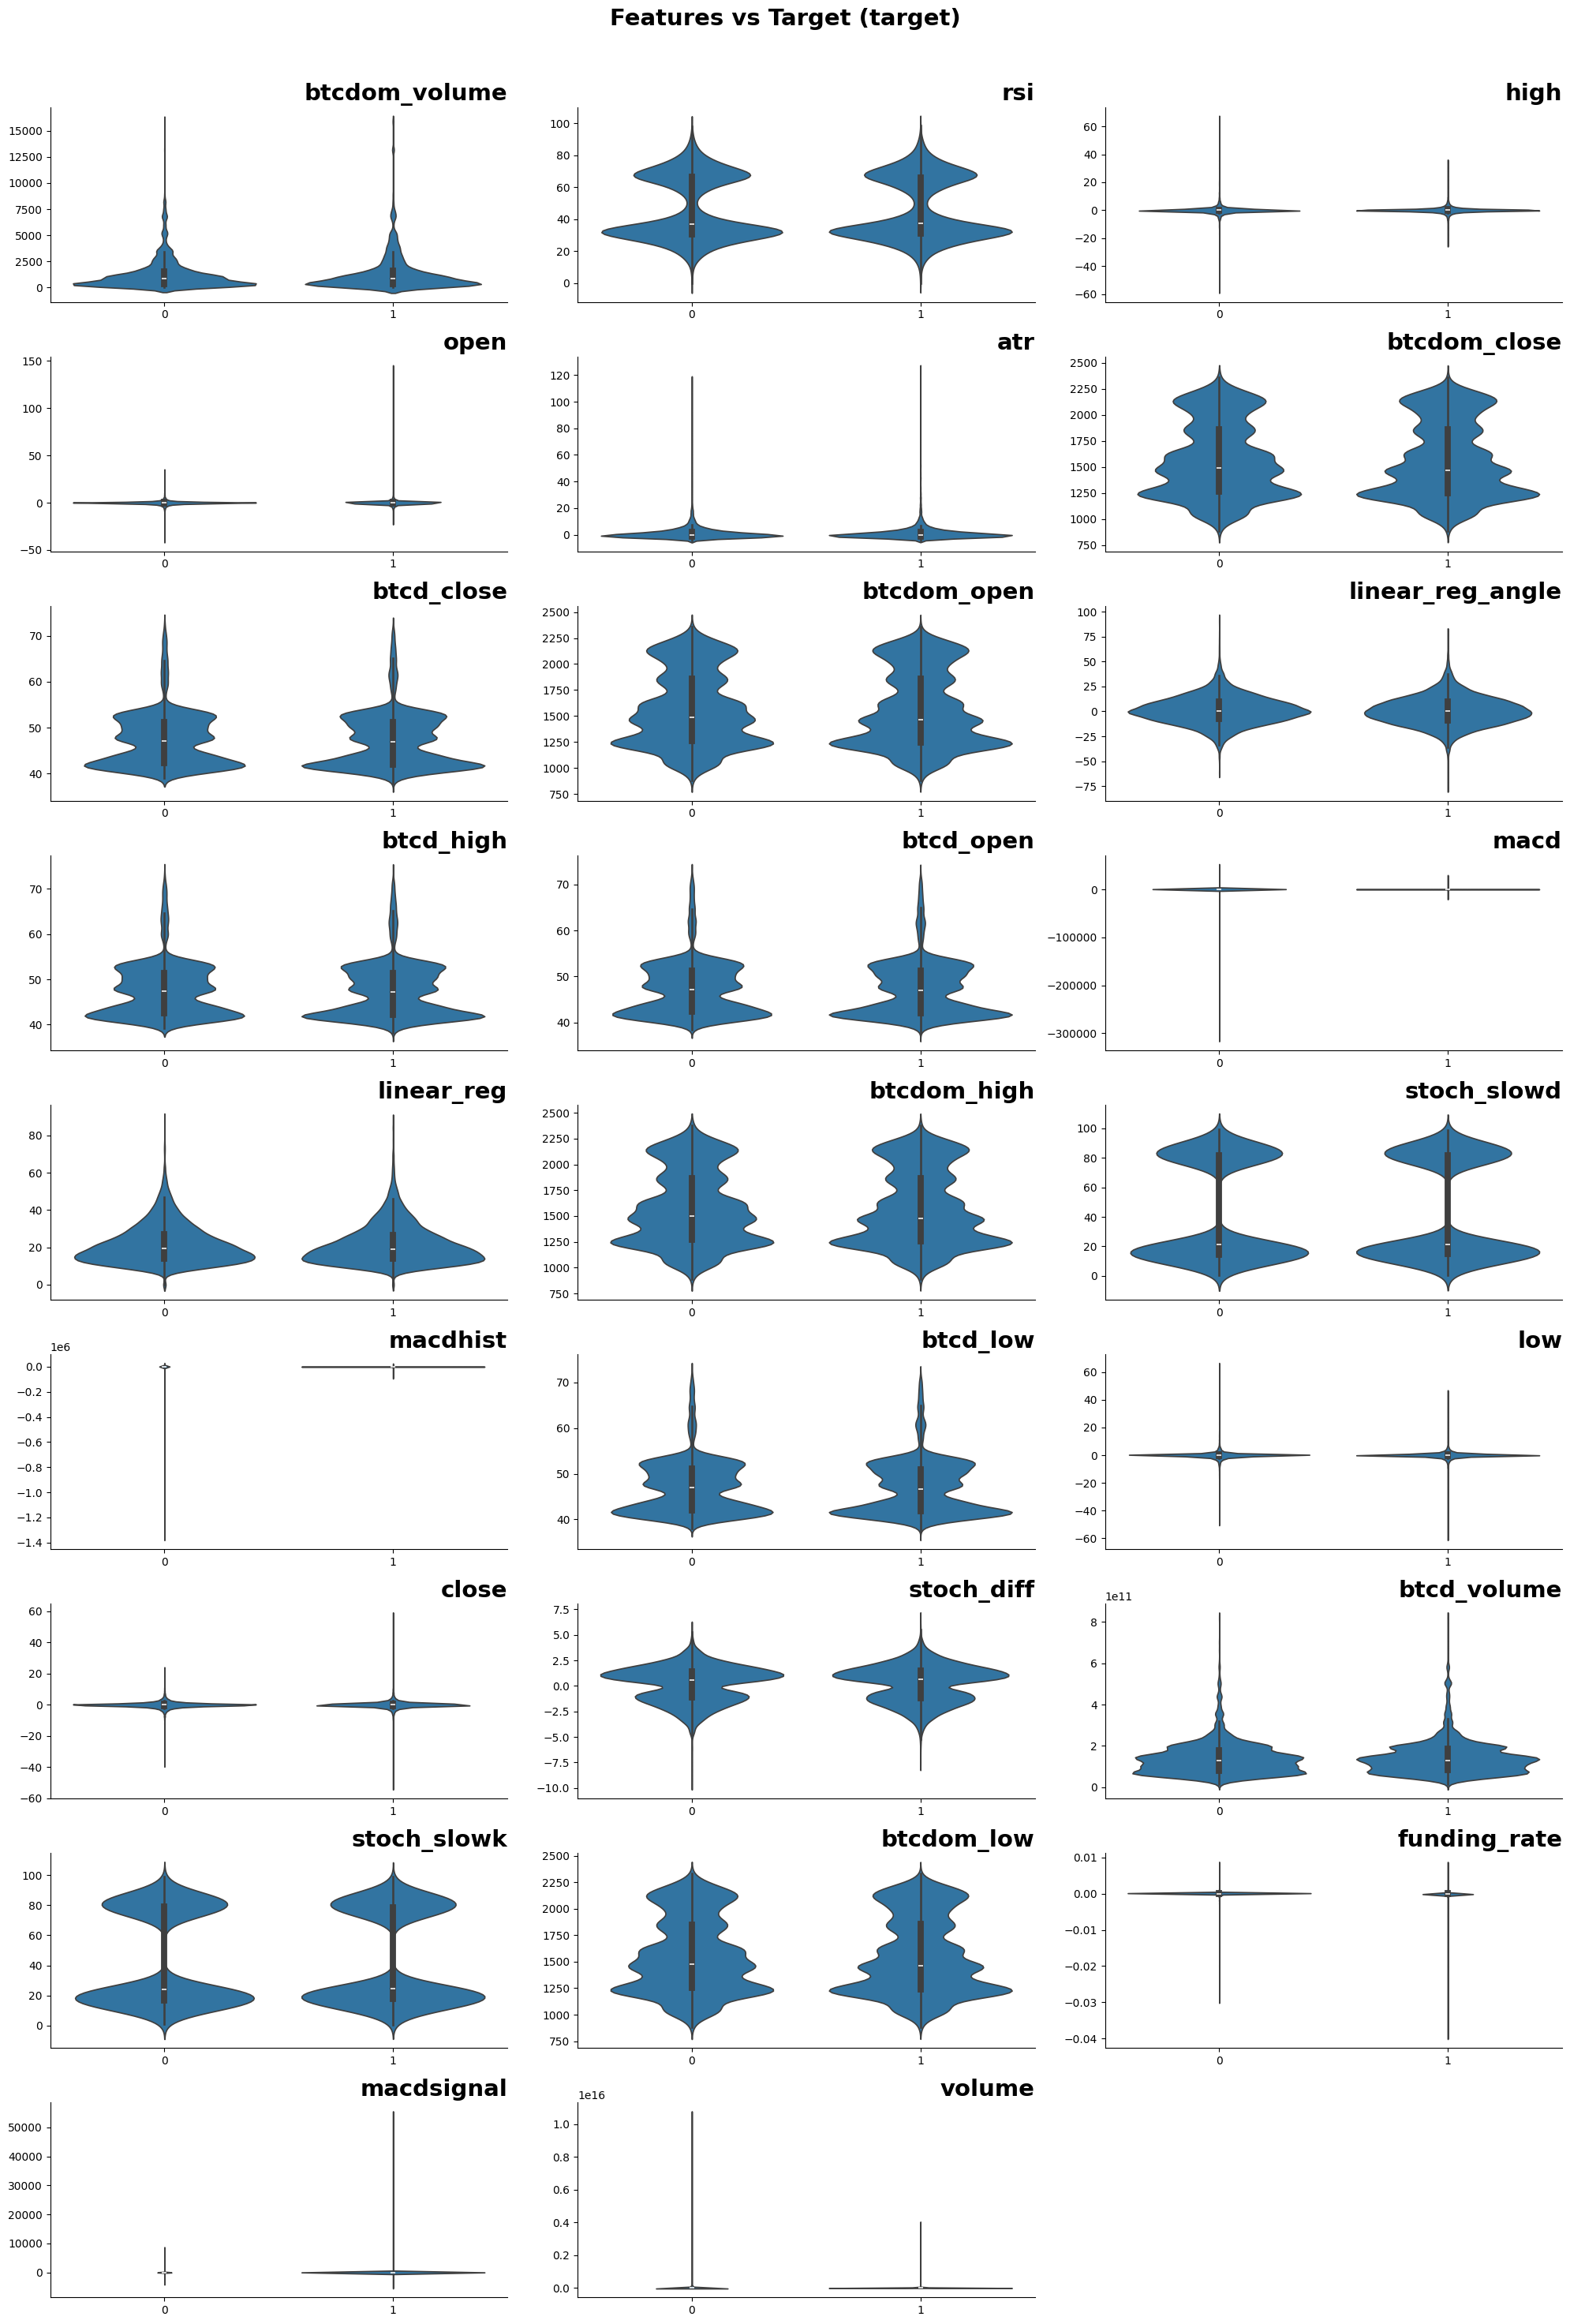

In [17]:
fi = pd.read_csv(f'feature_importance.csv')['Feature'].to_list()
cols = [c for c in fi if 'prev' not in c]
figsize = (20, 30)

def plot_target_violine(df, df_cols, n_rows, n_cols, target):
    fig = plt.figure(figsize=figsize)
    
    for idx, col in enumerate(df_cols):
        ax = plt.subplot(n_rows, n_cols, idx + 1)
        try:
            sns.violinplot(x=target, y=col, data=df)
        except ValueError:
            print(f"Can't find {col} in the dataframe")

        ax.set_ylabel(''); ax.spines['top'].set_visible(False), 
        ax.set_xlabel(''); ax.spines['right'].set_visible(False)
        ax.set_title(f'{col}', loc='right', weight='bold', fontsize=21)

    
    fig.suptitle(f'Features vs Target ({target})\n\n\n', ha='center',  fontweight='bold', fontsize=21)
    # fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
    plt.tight_layout()
    plt.show()
    
n_cols = 3
n_rows = len(cols) // n_cols + 1
plot_target_violine(train_df, cols, n_rows=n_rows, n_cols=n_cols, target='target') 

### Show the last signals

In [18]:
x = pd.read_pickle('signal_stat/buy_stat_1h.pkl')
x['ttype'] = 'buy'
y = pd.read_pickle('signal_stat/sell_stat_1h.pkl')
y['ttype'] = 'sell'
x = pd.concat([x, y]).sort_values('time').reset_index(drop=True)
x.loc[x['pattern'] == 'STOCH_RSI_Volume24', ['time', 'ticker', 'ttype', 'pattern']].tail(30)

,time,ticker,ttype,pattern
73132,2024-02-26 03:00:00,MNTUSDT,sell,STOCH_RSI_Volume24
73133,2024-02-26 04:00:00,SCPTUSDT,sell,STOCH_RSI_Volume24
73134,2024-02-26 04:00:00,LITTUSDT,sell,STOCH_RSI_Volume24
73135,2024-02-26 04:00:00,C98USDT,sell,STOCH_RSI_Volume24
73136,2024-02-26 04:00:00,DUELUSDT,sell,STOCH_RSI_Volume24
73137,2024-02-26 04:00:00,TLOSUSDT,sell,STOCH_RSI_Volume24
73138,2024-02-26 04:00:00,INJUSDT,sell,STOCH_RSI_Volume24
73139,2024-02-26 04:00:00,VICUSDT,sell,STOCH_RSI_Volume24
73140,2024-02-26 05:00:00,RPLUSDT,sell,STOCH_RSI_Volume24
73141,2024-02-26 05:00:00,ELFUSDT,sell,STOCH_RSI_Volume24


# Feature selection

### Select features with BORUTA feature importance

In [19]:
from shaphypetune import BoostBoruta
  
params = {
          'boosting_type': 'dart',
          'n_estimators': 1000,
          'learning_rate': 0.02,
          'max_depth': 10,
          'subsample' : 0.7,
          'colsample_bytree': 0.85,
          'num_leaves': 24,
          'verbosity': -1,
          'importance_type': 'gain',
          'max_bin': 255,
          'reg_alpha': 1e-6,
          'reg_lambda': 1e-7,
          'objective': 'binary',
          'metric': 'average_precision'
        }
features = [c for c in train_df.columns if c not in ['time', 'target', 'ticker', 'pattern', 'ttype']]



def boruta_selction(df):
    boruta_df_ = pd.DataFrame()

    X, y, time = df[features], df['target'], df['time']

    tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=CFG.n_folds, test_size=len(X) // int(CFG.n_folds * 1.5))
    eval_metric = 'logloss'

    # Stratify based on Class and Alpha (3 types of conditions)
    for fold, (train_idx, val_idx) in enumerate(tss.split(time)):

        print(f'Fold: {fold}')
        # Split the dataset according to the fold indexes.
        X_train = X.iloc[train_idx]
        X_val = X.iloc[val_idx]
        y_train = y.iloc[train_idx]
        y_val = y.iloc[val_idx]

        clf = lgb.LGBMClassifier(**params)
        model = BoostBoruta(clf, importance_type='shap_importances', train_importance=False, max_iter=1000)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)],  
                  eval_metric='logloss', 
                  callbacks=[lgb.log_evaluation(100)])

        boruta_importance_df = pd.DataFrame({'importance': model.ranking_}, index=X_train.columns).sort_index()
        if boruta_df_.shape[0] == 0:
            boruta_df_ = boruta_importance_df.copy()
        else:
            boruta_df_ += boruta_importance_df

    boruta_df_ = boruta_df_.sort_values('importance')
    boruta_df_ = boruta_df_.reset_index().rename({'index': 'Feature'}, axis=1)

    return boruta_df_


# if CFG.select_features:
#     boruta_df_ = boruta_selction(train_df)

### Select features with permutation importance and GBM feature importance

In [20]:
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

blk = Style.BRIGHT + Fore.BLACK
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

def lgbm_tuning(df, permut=False):
    outer_cv_score = [] # store all cv scores of outer loop inference

    perm_df_ = pd.DataFrame()
    feature_importances_ = pd.DataFrame()
    
    for fold in range(CFG.n_repeats):
        print(f'Repeat {blu}#{fold+1}')

        X, y, time = df[features], df['target'], df['time']
        tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=CFG.n_folds, test_size=len(X) // int(CFG.n_folds * 1.5))
        eval_metric = 'logloss'
        
        oof = np.zeros(len(df))
        
        # Stratify based on Class and Alpha (3 types of conditions)
        for fold, (train_idx, val_idx) in enumerate(tss.split(time)):
            if fold == 0:
                first_val_idx = val_idx[0]
            
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[train_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[train_idx]
            y_val = y.iloc[val_idx]

            clf = lgb.LGBMClassifier(**params)
            clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                    eval_metric=eval_metric, 
                    callbacks=[lgb.log_evaluation(100)])

            val_preds = clf.predict_proba(X_val)[:,1]
            val_score = log_loss(y_val, val_preds)
            
            oof[val_idx] = val_preds
            best_iter = clf.best_iteration_

            print(f'Fold: {blu}{fold + 1:>3}{res}| loss: {blu}{val_score:.5f}{res}| Best iteration: {blu}{best_iter:>4}{res}')

            # gboost feature importance
            f_i = pd.DataFrame(sorted(zip(clf.feature_importances_, X.columns), 
                                      reverse=True, key=lambda x: x[1]), 
                                      columns=['Value','Feature'])

            if feature_importances_.shape[0] == 0:
                feature_importances_ = f_i.copy()
            else:
                feature_importances_['Value'] += f_i['Value']
            
            # permutation importance
            if permut:
                perm = PermutationImportance(clf, scoring=None, n_iter=1, 
                                             random_state=42, cv=None, refit=False).fit(X_val, y_val)

                perm_importance_df = pd.DataFrame({'importance': perm.feature_importances_}, 
                                                    index=X_val.columns).sort_index()

                if perm_df_.shape[0] == 0:
                    perm_df_ = perm_importance_df.copy()
                else:
                    perm_df_ += perm_importance_df

        outer_cv = log_loss(y[first_val_idx:], oof[first_val_idx:])
        outer_cv_score.append(outer_cv)

    print(f'{red} Outer Holdout avg score: {res} log_loss: {red}{np.mean(outer_cv_score):.5f}{res}')
    print(f'{"*" * 50}\n')
    
    if permut:
        perm_df_ = perm_df_.sort_values('importance', ascending=False)
        perm_df_ = perm_df_.reset_index().rename({'index': 'Feature'}, axis=1)
                                    
    feature_importances_ = feature_importances_.sort_values('Value', ascending=False).reset_index(drop=True)
    
    return perm_df_, feature_importances_, np.mean(outer_cv_score)


if CFG.select_features:
    perm_df_, feature_importances_, outer_cv_score = lgbm_tuning(train_df, permut=True)

### RFE feature selection

In [21]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

def rfe_selection(df):
    params = {
          'penalty': 'l2',
          'max_iter': 10000,
          'C': 1
        }

    scaler = StandardScaler()
    X, y = df[features], df['target']
    X = scaler.fit_transform(X)
        
    estimator = LogisticRegression(**params)
    selector = RFECV(estimator, min_features_to_select=50, step=0.025, cv=5, verbose=1)
    selector = selector.fit(X, y)
    rfe_df_ = pd.DataFrame({'importance': selector.ranking_}, index=features).sort_index()
    rfe_df_ = rfe_df_.reset_index().rename({'index': 'Feature'}, axis=1)
    return rfe_df_

if CFG.select_features:
    rfe_df_ = rfe_selection(train_df)

### Combine importances and save them

In [22]:
if CFG.select_features:
    perm_df_['rank'] = perm_df_['importance'].rank(ascending=False)
    # boruta_df_['rank'] = boruta_df_['importance'].rank()
    rfe_df_['rank'] = rfe_df_['importance']
    feature_importances_['rank'] = feature_importances_['Value'].rank(ascending=False)

    fi = pd.concat([perm_df_[['Feature','rank']], feature_importances_[['Feature','rank']], rfe_df_[['Feature','rank']],])
                    # boruta_df_[['Feature','rank']]])
    fi = fi.groupby('Feature')['rank'].sum().sort_values().reset_index()
    fi.to_csv(f'feature_importance.csv')
else:
    fi = pd.read_csv(f'feature_importance.csv')

### Load selected features

In [23]:
def prepare_features(fi, feature_num, features_to_exclude):
    ''' Get features, sort them by their time appearance and return for using in train and inference'''
    # exclude some features 
    fi = fi['Feature']
    fi = [f for f in fi if f not in features_to_exclude]
    fi = fi[:feature_num]
    feature_dict = defaultdict(list)
    features = list()
    
    for f in fi:
        if f == 'volume_24':
            feature_dict[0].append(f)
            continue
        period = f.split('_')
        if period[-1].isdigit():
            feature_dict[int(period[-1])].append('_'.join(period[:-2]))
        else:
            feature_dict[0].append(f)

    feature_dict = dict(sorted(feature_dict.items()))
    
    for item in feature_dict.items():
        if item[0] > 0:
            features.extend([i + f'_prev_{item[0]}' for i in item[1]])
        else:
            features.extend([i for i in item[1]])

    feature_dict['features'] = features # + ['Pattern_Trend', 'STOCH_RSI']

    return features, feature_dict

train_df['weekday'] = train_df['time'].dt.weekday
fi = pd.read_csv(f'feature_importance.csv')
feature_num = 430
features_to_exclude = []
features, feature_dict = prepare_features(fi, feature_num, features_to_exclude)
features = features + ['weekday']
display(features)

['btcdom_volume',
 'rsi',
 'high',
 'open',
 'atr',
 'btcdom_close',
 'btcd_close',
 'btcdom_open',
 'linear_reg_angle',
 'btcd_high',
 'btcd_open',
 'macd',
 'linear_reg',
 'btcdom_high',
 'stoch_slowd',
 'macdhist',
 'btcd_low',
 'low',
 'close',
 'rsi_prev_4',
 'btcdom_close_prev_4',
 'stoch_diff_prev_4',
 'btcdom_volume_prev_4',
 'atr_prev_4',
 'high_prev_4',
 'close_prev_4',
 'low_prev_4',
 'stoch_slowk_prev_4',
 'macdhist_prev_4',
 'btcdom_high_prev_4',
 'linear_reg_angle_prev_4',
 'linear_reg_prev_4',
 'rsi_prev_8',
 'stoch_diff_prev_8',
 'linear_reg_angle_prev_8',
 'stoch_slowd_prev_8',
 'high_prev_8',
 'macdhist_prev_8',
 'close_prev_8',
 'btcdom_close_prev_8',
 'btcdom_volume_prev_8',
 'btcdom_volume_prev_12',
 'low_prev_12',
 'high_prev_12',
 'linear_reg_angle_prev_12',
 'stoch_slowd_prev_12',
 'stoch_diff_prev_12',
 'btcdom_volume_prev_16',
 'rsi_prev_16',
 'close_prev_16',
 'linear_reg_angle_prev_16',
 'btcdom_open_prev_16',
 'rsi_prev_20',
 'close_prev_20',
 'volume_prev_

### Show the features that correlate with other features too much (corr >= 0.8) and are not too important

In [24]:
if CFG.select_features:
    features_to_select = features.copy()
    correlations = train_df.loc[:, features_to_select].corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
    correlations = correlations[correlations['level_0'] != correlations['level_1']] 
    correlations.columns = ['feature_1', 'feature_2', 'corr']

    correlations = pd.merge(left=correlations, right=fi, how='left', left_on='feature_1', right_on='Feature')
    correlations = correlations.drop(columns='Feature')
    correlations = correlations.sort_values(['rank', 'feature_1'])

    features_to_exclude = list()
    corr_thresh = 0.8

    for i, row in correlations.iterrows():
        feature_1 = row['feature_1']
        feature_2 = row['feature_2']
        corr = row['corr']

        if feature_1 in features_to_exclude:
            continue

        if corr > corr_thresh:
            features_to_exclude.append(feature_2)

    display(set(features_to_exclude))

# Train

### Functions for train and optimization

In [25]:
val_idxs = list()
with open(f'bybit_tickers.json', 'r') as f:
    bybit_tickers = json.load(f)

def confident_score(y, oof, low_bound, high_bound):
    ''' Consider only high confident objects for accuracy and precision scores calculation;
        object probability must be lower than low_bound or higher than high_bound '''
    pred_conf = np.zeros_like(oof)
    pred_conf[oof > high_bound] = 1
    pred_conf_prec = pred_conf[(oof > high_bound)]
    y_conf_prec = y.values.reshape(-1,1)[(oof > high_bound)]
    if y_conf_prec.shape[0] == 0:
        return 0, 0, 0
    return precision_score(y_conf_prec, pred_conf_prec), y_conf_prec.shape[0], y_conf_prec.shape[0]/y.shape[0]

def model_train(df, features, params, n_folds, low_bound, high_bound, train_test, verbose=False): 
    X, time = df[features], df['time']
    y = df['target']
    
    if train_test == 'fold':
        oof = np.zeros([len(df), 1])

        tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=n_folds, test_size=(len(df) * 2) // (n_folds * 3))

        if verbose:
            print(f"Training with {len(features)} features")
        
        for fold, (fit_idx, val_idx) in enumerate(tss.split(time)):
            # select only those val_idxs that correspond to 
            # time = max train dataset time + 96 hours to prevent data leakage
            max_time = time[fit_idx].max() + pd.to_timedelta(96, unit='h')
            # also select only tickers from ByBit for validation because we trade on ByBit only
            val_idx = time[(time > max_time) & (df['ticker'].isin(bybit_tickers))].index.tolist()
            
            val_idxs.extend(val_idx)
            
            if verbose:
                print(f'Fold #{fold + 1}')
            
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[fit_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[fit_idx]
            y_val = y.iloc[val_idx]

            if verbose:
                display(y_val.value_counts(normalize=True))
                display(df.loc[val_idx[0], 'time'])
                display(df.loc[val_idx[-1], 'time'])
                callbacks = [lgb.log_evaluation(100)]
            else:
                callbacks = []
            
            model_lgb = lgb.LGBMClassifier(**params)
            model_lgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], 
                          eval_metric='logloss', callbacks=callbacks)

            val_preds = model_lgb.predict_proba(X_val)
        
            val_score = log_loss(y_val, val_preds)
            prec_score, prec_obj_num, prec_obj_pct = confident_score(y_val, val_preds[:, 1], low_bound, high_bound)
            if verbose:
                print(f'Logloss: {val_score}, Confident objects precision: {prec_score}\n'
                      f'Number of confident objects {prec_obj_num}, % of confident objects: {prec_obj_pct}\n'
                      f'Number of profitable objects: {round((2 * prec_score -  1) * prec_obj_num)}')
            oof[val_idx, 0] = val_preds[:,1]
        
        return oof, model_lgb, sorted(list(set(val_idxs)))
    elif train_test == 'full':
        print('Train on full data')
        X, y = df[features], df['target']
        
        model_lgb = lgb.LGBMClassifier(**params)
        model_lgb.fit(X, y, eval_set=[(X, y)], eval_metric='logloss', callbacks = [lgb.log_evaluation(100)])
        
        return np.zeros([df.shape[0], 1]), model_lgb, None

def objective(trial):
    params = {
        # Main parameters
#                     'device': 'gpu',
#                     'gpu_platform_id': 0,
#                     'gpu_device_id': 0,
        'objective': 'binary',
        'metric': 'average_precision',
        'boosting_type': trial.suggest_categorical('boosting_type', ['dart', 'goss', 'gbdt']),   
        # Hyperparamters (in order of importance decreasing)
        'n_estimators': trial.suggest_int('n_estimators', 500, 3000),  # max number of trees in model
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 3e-1),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True), # L1,  alias: lambda_l1
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True), # L2, alias: lambda_l2
         # decrease to deal with overfit
        'max_depth': trial.suggest_int('max_depth', 4, 10),   # tree max depth 
         # decrease to deal with overfit
        'num_leaves': trial.suggest_int('num_leaves', 4, 512),  # Max number of leaves in one tree
                                                                # should be ~ 2**(max_depth-1)
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.9), # Randomly select a subset of features 
                                                                   # if colsample_bytree < 1.0
                                                                   # alias:feature_fraction
        # increase for accuracy, decrease to deal with overfit
        'max_bin': trial.suggest_int('max_bin', 32, 255), # Max number of bins that feature values will be bucketed in
        # increase to deal with overfit
        'subsample_freq': 1, # Perform bagging at every k iteration, alias: bagging_freq

#           'subsample_for_bin': 200000, # Number of data that sampled to construct feature discrete bins; setting this 
                                     # to larger value will give better training result but may increase train time 
#           'cat_smooth': trial.suggest_float('cat_smooth', 10.0, 100.0),  # this can reduce the effect of noises in 
                                                                       # categorical features, especially for 
                                                                       # categories with few data
        'is_unbalance': trial.suggest_categorical('is_unbalance', [True, False]),                                                        
        'verbose': -1,
        
        'high_bound': 0.5,
        'feature_num': trial.suggest_int('feature_num', 50, 500),
        'importance_type': 'gain'
    }

    if params['is_unbalance'] is True:
        params['class_weight'] = 'balanced'
    
    if params['boosting_type'] != 'goss':
        params['subsample'] = trial.suggest_float('subsample', 0.3, 0.9)

    high_bound = params['high_bound']
    low_bound = 1 - high_bound
    del params['high_bound']
    
    fi = pd.read_csv(f'feature_importance.csv')
    feature_num = params['feature_num']
    del params['feature_num']
    
    train_df['weekday'] = train_df['time'].dt.weekday
    features_to_exclude = list()
    features, _ = prepare_features(fi, feature_num, features_to_exclude)
    features = features + ['weekday']
    
    oof, __, val_idxs = model_train(train_df, features, params, n_folds=8, low_bound=low_bound, high_bound=high_bound, 
                                    train_test='fold')
    y = train_df['target'][val_idxs]
    oof = oof[val_idxs]
    oof_conf_prec_score, oof_conf_obj_num, oof_conf_obj_pct = confident_score(y, oof, low_bound, high_bound)
    oof_val_score = log_loss(y, oof)
    res = oof_conf_obj_num * (oof_conf_prec_score-0.55) * 100
    # save dataframe with additional information
    df_optuna_more_info = pd.read_csv('optuna_lgbm_info.csv')
    profit_objects = round(oof_conf_obj_num * (2 * oof_conf_prec_score - 1))
    tmp = pd.DataFrame({'value': [res], 'oof_conf_prec_score': [oof_conf_prec_score], 
                        'profit_objects': [profit_objects], 'oof_val_score': [oof_val_score], 
                        'oof_conf_obj_num': [oof_conf_obj_num], 'oof_conf_obj_pct': [oof_conf_obj_pct], 
                        })
    df_optuna_more_info = pd.concat([df_optuna_more_info, tmp])
    df_optuna_more_info.to_csv('optuna_lgbm_info.csv', index=False)
    return res

### Train / optimize process

In [33]:
# params = {
#     'boosting_type': 'gbdt',
#     'n_estimators': 2029,
#     'learning_rate': 0.0029802079941887525,
#     'reg_alpha': 0.0003050568761042403,
#     'reg_lambda': 1.602614646722288e-05,
#     'max_depth': 4,
#     'num_leaves': 500,
#     'colsample_bytree': 0.8644932085440681,
#     'max_bin': 73,
#     'is_unbalance': True,
#     'class_weight': 'balanced',
#     'feature_num': 64,
#     'subsample_freq': 1,
#     'subsample': 0.3281862009667817,
#     'objective': 'binary',
#     'importance_type': 'gain',
#     'metric': 'average_precision',
#     'verbosity': -1
#     }

params = {
    'boosting_type': 'goss',
    'n_estimators': 2935,
    'learning_rate': 0.000101,
    'max_depth': 10,
    'colsample_bytree': 0.86448,
    # 'subsample': 0.5394907029626385,
    'subsample_freq': 1,
    'num_leaves': 37,
    'verbosity': -1,
    'max_bin': 229,
    'reg_alpha': 0.050818,
    'reg_lambda': 2.192784e-08,
    'is_unbalance': True,
    'class_weight': 'balanced',
    'objective': 'binary',
    'importance_type': 'gain',
    'metric': 'average_precision'
    }

train_test = 'fold' # fold, full
high_bound = 0.5
low_bound = 1 - high_bound
last_date = '2024-01-28'

if CFG.optimize:
    df_optuna_more_info = pd.DataFrame(columns=['value', 'oof_conf_prec_score', 'profit_objects', 
                                                'oof_val_score', 'oof_conf_obj_num', 'oof_conf_obj_pct'])
    df_optuna_more_info.to_csv('optuna_lgbm_info.csv', index=False)
    
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=500)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    df_optuna = study.trials_dataframe()
    df_optuna = df_optuna.sort_values('value', ascending=False)
    df_optuna.to_csv(f'optuna_lgbm.csv')

    display(df_optuna.head(10))
elif train_test == 'fold':
    # fold
    oof, _, val_idxs = model_train(train_df, features, params, n_folds=8, low_bound=low_bound, high_bound=high_bound, 
                                   train_test=train_test, verbose=True)
    y = train_df['target'][val_idxs]
    oof = oof[val_idxs]
    oof_val_score = log_loss(y, oof)
    oof_conf_prec_score, oof_conf_obj_num, oof_conf_obj_pct = confident_score(y, oof, low_bound, high_bound)
    print(f'Total fold Logloss: {oof_val_score}, Total confident objects precision: {oof_conf_prec_score}\n'
            f'Number of confident objects: {oof_conf_obj_num}, Total % of confident objects: {oof_conf_obj_pct}\n' 
            f'Number of profitable objects: {round(( 2 * oof_conf_prec_score - 1) * oof_conf_obj_num)}')
elif train_test == 'full':
    oof, model, val_idxs = model_train(train_df[train_df['time'] < last_date], features, params, n_folds=5, low_bound=low_bound, 
                                       high_bound=high_bound, train_test=train_test, verbose=True)
    joblib.dump(model, f'lgbm.pkl')
    # save feature dictionary for further inference
    with open(f'features.json', 'w') as f:
        json.dump(feature_dict, f)

Training with 431 features
Fold #1


1    0.539165
0    0.460835
Name: target, dtype: float64

Timestamp('2022-06-23 03:00:00')

Timestamp('2024-02-25 23:00:00')

[100]	training's binary_logloss: 0.691576	training's average_precision: 0.796643	valid_1's binary_logloss: 0.693294	valid_1's average_precision: 0.544073
[200]	training's binary_logloss: 0.690032	training's average_precision: 0.801131	valid_1's binary_logloss: 0.693442	valid_1's average_precision: 0.545296
[300]	training's binary_logloss: 0.688498	training's average_precision: 0.800312	valid_1's binary_logloss: 0.693524	valid_1's average_precision: 0.546236
[400]	training's binary_logloss: 0.686981	training's average_precision: 0.801648	valid_1's binary_logloss: 0.693604	valid_1's average_precision: 0.546396
[500]	training's binary_logloss: 0.685486	training's average_precision: 0.802922	valid_1's binary_logloss: 0.693727	valid_1's average_precision: 0.546008
[600]	training's binary_logloss: 0.684007	training's average_precision: 0.803879	valid_1's binary_logloss: 0.693848	valid_1's average_precision: 0.545124
[700]	training's binary_logloss: 0.682547	training's average_precision: 0.80

1    0.545915
0    0.454085
Name: target, dtype: float64

Timestamp('2022-09-18 04:00:00')

Timestamp('2024-02-25 23:00:00')

[100]	training's binary_logloss: 0.691743	training's average_precision: 0.76758	valid_1's binary_logloss: 0.692951	valid_1's average_precision: 0.577557
[200]	training's binary_logloss: 0.690352	training's average_precision: 0.773608	valid_1's binary_logloss: 0.69274	valid_1's average_precision: 0.581523
[300]	training's binary_logloss: 0.688987	training's average_precision: 0.772788	valid_1's binary_logloss: 0.69258	valid_1's average_precision: 0.581917
[400]	training's binary_logloss: 0.687632	training's average_precision: 0.774611	valid_1's binary_logloss: 0.692411	valid_1's average_precision: 0.581897
[500]	training's binary_logloss: 0.686295	training's average_precision: 0.775391	valid_1's binary_logloss: 0.692266	valid_1's average_precision: 0.581825
[600]	training's binary_logloss: 0.68498	training's average_precision: 0.776945	valid_1's binary_logloss: 0.692186	valid_1's average_precision: 0.581927
[700]	training's binary_logloss: 0.683674	training's average_precision: 0.779158

1    0.534154
0    0.465846
Name: target, dtype: float64

Timestamp('2023-01-07 04:00:00')

Timestamp('2024-02-25 23:00:00')

[100]	training's binary_logloss: 0.691823	training's average_precision: 0.750474	valid_1's binary_logloss: 0.692956	valid_1's average_precision: 0.537787
[200]	training's binary_logloss: 0.690524	training's average_precision: 0.756696	valid_1's binary_logloss: 0.692813	valid_1's average_precision: 0.537835
[300]	training's binary_logloss: 0.689247	training's average_precision: 0.755311	valid_1's binary_logloss: 0.692616	valid_1's average_precision: 0.539722
[400]	training's binary_logloss: 0.687991	training's average_precision: 0.755781	valid_1's binary_logloss: 0.692464	valid_1's average_precision: 0.537698
[500]	training's binary_logloss: 0.686747	training's average_precision: 0.75739	valid_1's binary_logloss: 0.692352	valid_1's average_precision: 0.535744
[600]	training's binary_logloss: 0.685535	training's average_precision: 0.761432	valid_1's binary_logloss: 0.692231	valid_1's average_precision: 0.534176
[700]	training's binary_logloss: 0.684339	training's average_precision: 0.764

1    0.543624
0    0.456376
Name: target, dtype: float64

Timestamp('2023-04-05 04:00:00')

Timestamp('2024-02-25 23:00:00')

[100]	training's binary_logloss: 0.691899	training's average_precision: 0.740653	valid_1's binary_logloss: 0.693164	valid_1's average_precision: 0.569427
[200]	training's binary_logloss: 0.690677	training's average_precision: 0.746841	valid_1's binary_logloss: 0.693162	valid_1's average_precision: 0.566466
[300]	training's binary_logloss: 0.689464	training's average_precision: 0.746173	valid_1's binary_logloss: 0.693181	valid_1's average_precision: 0.566762
[400]	training's binary_logloss: 0.688275	training's average_precision: 0.746921	valid_1's binary_logloss: 0.693192	valid_1's average_precision: 0.566484
[500]	training's binary_logloss: 0.687096	training's average_precision: 0.747329	valid_1's binary_logloss: 0.693216	valid_1's average_precision: 0.565643
[600]	training's binary_logloss: 0.685932	training's average_precision: 0.746985	valid_1's binary_logloss: 0.693239	valid_1's average_precision: 0.565329
[700]	training's binary_logloss: 0.684791	training's average_precision: 0.74

1    0.561147
0    0.438853
Name: target, dtype: float64

Timestamp('2023-06-10 16:00:00')

Timestamp('2024-02-25 23:00:00')

[100]	training's binary_logloss: 0.691916	training's average_precision: 0.739679	valid_1's binary_logloss: 0.693066	valid_1's average_precision: 0.567444
[200]	training's binary_logloss: 0.690707	training's average_precision: 0.743515	valid_1's binary_logloss: 0.692983	valid_1's average_precision: 0.56676
[300]	training's binary_logloss: 0.689524	training's average_precision: 0.74831	valid_1's binary_logloss: 0.692882	valid_1's average_precision: 0.565262
[400]	training's binary_logloss: 0.688354	training's average_precision: 0.751179	valid_1's binary_logloss: 0.692836	valid_1's average_precision: 0.561108
[500]	training's binary_logloss: 0.687198	training's average_precision: 0.752797	valid_1's binary_logloss: 0.692783	valid_1's average_precision: 0.559398
[600]	training's binary_logloss: 0.686054	training's average_precision: 0.753654	valid_1's binary_logloss: 0.692757	valid_1's average_precision: 0.562235
[700]	training's binary_logloss: 0.684927	training's average_precision: 0.7542

1    0.568719
0    0.431281
Name: target, dtype: float64

Timestamp('2023-08-29 01:00:00')

Timestamp('2024-02-25 23:00:00')

[100]	training's binary_logloss: 0.691989	training's average_precision: 0.733215	valid_1's binary_logloss: 0.693198	valid_1's average_precision: 0.556438
[200]	training's binary_logloss: 0.690851	training's average_precision: 0.737867	valid_1's binary_logloss: 0.693254	valid_1's average_precision: 0.555361
[300]	training's binary_logloss: 0.689728	training's average_precision: 0.738284	valid_1's binary_logloss: 0.69331	valid_1's average_precision: 0.556987
[400]	training's binary_logloss: 0.688632	training's average_precision: 0.743267	valid_1's binary_logloss: 0.693326	valid_1's average_precision: 0.559001
[500]	training's binary_logloss: 0.687543	training's average_precision: 0.745849	valid_1's binary_logloss: 0.693311	valid_1's average_precision: 0.561713
[600]	training's binary_logloss: 0.686451	training's average_precision: 0.749199	valid_1's binary_logloss: 0.69321	valid_1's average_precision: 0.564314
[700]	training's binary_logloss: 0.685375	training's average_precision: 0.7521

1    0.561143
0    0.438857
Name: target, dtype: float64

Timestamp('2023-11-15 14:00:00')

Timestamp('2024-02-25 23:00:00')

[100]	training's binary_logloss: 0.69211	training's average_precision: 0.723265	valid_1's binary_logloss: 0.693072	valid_1's average_precision: 0.60576
[200]	training's binary_logloss: 0.691086	training's average_precision: 0.728634	valid_1's binary_logloss: 0.692976	valid_1's average_precision: 0.607409
[300]	training's binary_logloss: 0.690081	training's average_precision: 0.727474	valid_1's binary_logloss: 0.692875	valid_1's average_precision: 0.607733
[400]	training's binary_logloss: 0.689094	training's average_precision: 0.72776	valid_1's binary_logloss: 0.692785	valid_1's average_precision: 0.607571
[500]	training's binary_logloss: 0.688125	training's average_precision: 0.729407	valid_1's binary_logloss: 0.692719	valid_1's average_precision: 0.60559
[600]	training's binary_logloss: 0.687169	training's average_precision: 0.730505	valid_1's binary_logloss: 0.69265	valid_1's average_precision: 0.603239
[700]	training's binary_logloss: 0.686226	training's average_precision: 0.731442	

1    0.569067
0    0.430933
Name: target, dtype: float64

Timestamp('2024-01-13 18:00:00')

Timestamp('2024-02-25 23:00:00')

[100]	training's binary_logloss: 0.692224	training's average_precision: 0.706349	valid_1's binary_logloss: 0.692992	valid_1's average_precision: 0.673187
[200]	training's binary_logloss: 0.691314	training's average_precision: 0.71048	valid_1's binary_logloss: 0.692811	valid_1's average_precision: 0.677445
[300]	training's binary_logloss: 0.690423	training's average_precision: 0.710208	valid_1's binary_logloss: 0.692657	valid_1's average_precision: 0.675942
[400]	training's binary_logloss: 0.689542	training's average_precision: 0.710927	valid_1's binary_logloss: 0.692564	valid_1's average_precision: 0.670025
[500]	training's binary_logloss: 0.688672	training's average_precision: 0.712203	valid_1's binary_logloss: 0.692433	valid_1's average_precision: 0.666824
[600]	training's binary_logloss: 0.687816	training's average_precision: 0.712772	valid_1's binary_logloss: 0.692298	valid_1's average_precision: 0.665394
[700]	training's binary_logloss: 0.686972	training's average_precision: 0.713

In [27]:
# Training with 431 features
# Fold #1
# 1    0.539165
# 0    0.460835
# Name: target, dtype: float64Timestamp('2022-06-23 03:00:00')Timestamp('2024-02-25 23:00:00')
# [100]	training's binary_logloss: 0.67479	training's average_precision: 0.757635	valid_1's binary_logloss: 0.691522	valid_1's average_precision: 0.573178
# [200]	training's binary_logloss: 0.660772	training's average_precision: 0.773358	valid_1's binary_logloss: 0.691488	valid_1's average_precision: 0.578236
# [300]	training's binary_logloss: 0.649436	training's average_precision: 0.786527	valid_1's binary_logloss: 0.69205	valid_1's average_precision: 0.572228
# [400]	training's binary_logloss: 0.639948	training's average_precision: 0.797457	valid_1's binary_logloss: 0.692415	valid_1's average_precision: 0.570955
# [500]	training's binary_logloss: 0.631646	training's average_precision: 0.807876	valid_1's binary_logloss: 0.692639	valid_1's average_precision: 0.570382
# [600]	training's binary_logloss: 0.624071	training's average_precision: 0.81716	valid_1's binary_logloss: 0.692828	valid_1's average_precision: 0.569543
# [700]	training's binary_logloss: 0.617051	training's average_precision: 0.825459	valid_1's binary_logloss: 0.692881	valid_1's average_precision: 0.568919
# [800]	training's binary_logloss: 0.610121	training's average_precision: 0.833441	valid_1's binary_logloss: 0.692943	valid_1's average_precision: 0.569407
# [900]	training's binary_logloss: 0.603653	training's average_precision: 0.840844	valid_1's binary_logloss: 0.693321	valid_1's average_precision: 0.570013
# [1000]	training's binary_logloss: 0.597544	training's average_precision: 0.847185	valid_1's binary_logloss: 0.693683	valid_1's average_precision: 0.568734
# [1100]	training's binary_logloss: 0.591644	training's average_precision: 0.853581	valid_1's binary_logloss: 0.693884	valid_1's average_precision: 0.568235
# [1200]	training's binary_logloss: 0.585965	training's average_precision: 0.859371	valid_1's binary_logloss: 0.694113	valid_1's average_precision: 0.568736
# [1300]	training's binary_logloss: 0.580365	training's average_precision: 0.864825	valid_1's binary_logloss: 0.694491	valid_1's average_precision: 0.567735
# [1400]	training's binary_logloss: 0.574926	training's average_precision: 0.870584	valid_1's binary_logloss: 0.694571	valid_1's average_precision: 0.567646
# [1500]	training's binary_logloss: 0.569693	training's average_precision: 0.876427	valid_1's binary_logloss: 0.694827	valid_1's average_precision: 0.566671
# [1600]	training's binary_logloss: 0.5646	training's average_precision: 0.881661	valid_1's binary_logloss: 0.695156	valid_1's average_precision: 0.566185
# [1700]	training's binary_logloss: 0.559198	training's average_precision: 0.886839	valid_1's binary_logloss: 0.695317	valid_1's average_precision: 0.566238
# [1800]	training's binary_logloss: 0.554223	training's average_precision: 0.891488	valid_1's binary_logloss: 0.695684	valid_1's average_precision: 0.565779
# [1900]	training's binary_logloss: 0.549503	training's average_precision: 0.895486	valid_1's binary_logloss: 0.69596	valid_1's average_precision: 0.565015
# [2000]	training's binary_logloss: 0.544918	training's average_precision: 0.899292	valid_1's binary_logloss: 0.696164	valid_1's average_precision: 0.564792
# Logloss: 0.696266793098546, Confident objects precision: 0.5520681770941592
# Number of confident objects 4811, % of confident objects: 0.61076551986797
# Number of profitable objects: 501
# Fold #2
# 1    0.545915
# 0    0.454085
# Name: target, dtype: float64Timestamp('2022-09-18 04:00:00')Timestamp('2024-02-25 23:00:00')
# [100]	training's binary_logloss: 0.675417	training's average_precision: 0.73676	valid_1's binary_logloss: 0.692943	valid_1's average_precision: 0.591381
# [200]	training's binary_logloss: 0.662157	training's average_precision: 0.752766	valid_1's binary_logloss: 0.691711	valid_1's average_precision: 0.589431
# [300]	training's binary_logloss: 0.65175	training's average_precision: 0.763545	valid_1's binary_logloss: 0.690869	valid_1's average_precision: 0.586676
# [400]	training's binary_logloss: 0.64288	training's average_precision: 0.77389	valid_1's binary_logloss: 0.690793	valid_1's average_precision: 0.58512
# [500]	training's binary_logloss: 0.635169	training's average_precision: 0.782882	valid_1's binary_logloss: 0.690194	valid_1's average_precision: 0.584479
# [600]	training's binary_logloss: 0.628252	training's average_precision: 0.792216	valid_1's binary_logloss: 0.690616	valid_1's average_precision: 0.586118
# [700]	training's binary_logloss: 0.621753	training's average_precision: 0.801262	valid_1's binary_logloss: 0.690548	valid_1's average_precision: 0.584009
# [800]	training's binary_logloss: 0.615616	training's average_precision: 0.809024	valid_1's binary_logloss: 0.690847	valid_1's average_precision: 0.583473
# [900]	training's binary_logloss: 0.609822	training's average_precision: 0.816518	valid_1's binary_logloss: 0.690765	valid_1's average_precision: 0.583287
# [1000]	training's binary_logloss: 0.604339	training's average_precision: 0.823516	valid_1's binary_logloss: 0.691002	valid_1's average_precision: 0.580986
# [1100]	training's binary_logloss: 0.599042	training's average_precision: 0.829219	valid_1's binary_logloss: 0.691092	valid_1's average_precision: 0.579226
# [1200]	training's binary_logloss: 0.594136	training's average_precision: 0.835183	valid_1's binary_logloss: 0.691811	valid_1's average_precision: 0.579316
# [1300]	training's binary_logloss: 0.589025	training's average_precision: 0.84093	valid_1's binary_logloss: 0.691956	valid_1's average_precision: 0.578332
# [1400]	training's binary_logloss: 0.584312	training's average_precision: 0.846459	valid_1's binary_logloss: 0.692038	valid_1's average_precision: 0.577324
# [1500]	training's binary_logloss: 0.579718	training's average_precision: 0.852236	valid_1's binary_logloss: 0.692376	valid_1's average_precision: 0.575882
# [1600]	training's binary_logloss: 0.575218	training's average_precision: 0.857435	valid_1's binary_logloss: 0.692463	valid_1's average_precision: 0.574908
# [1700]	training's binary_logloss: 0.570706	training's average_precision: 0.862259	valid_1's binary_logloss: 0.692764	valid_1's average_precision: 0.57499
# [1800]	training's binary_logloss: 0.566405	training's average_precision: 0.867088	valid_1's binary_logloss: 0.692904	valid_1's average_precision: 0.573645
# [1900]	training's binary_logloss: 0.562221	training's average_precision: 0.871394	valid_1's binary_logloss: 0.693088	valid_1's average_precision: 0.573459
# [2000]	training's binary_logloss: 0.558039	training's average_precision: 0.875167	valid_1's binary_logloss: 0.693589	valid_1's average_precision: 0.572645
# Logloss: 0.6936397940974266, Confident objects precision: 0.5556906614785992
# Number of confident objects 4112, % of confident objects: 0.5955967555040557
# Number of profitable objects: 458
# Fold #3
# 1    0.534154
# 0    0.465846
# Name: target, dtype: float64Timestamp('2023-01-07 04:00:00')Timestamp('2024-02-25 23:00:00')
# [100]	training's binary_logloss: 0.676444	training's average_precision: 0.72993	valid_1's binary_logloss: 0.691047	valid_1's average_precision: 0.558616
# [200]	training's binary_logloss: 0.664346	training's average_precision: 0.744092	valid_1's binary_logloss: 0.689922	valid_1's average_precision: 0.554324
# [300]	training's binary_logloss: 0.654795	training's average_precision: 0.754622	valid_1's binary_logloss: 0.689323	valid_1's average_precision: 0.55229
# [400]	training's binary_logloss: 0.646746	training's average_precision: 0.76454	valid_1's binary_logloss: 0.689424	valid_1's average_precision: 0.551188
# [500]	training's binary_logloss: 0.640027	training's average_precision: 0.7741	valid_1's binary_logloss: 0.689589	valid_1's average_precision: 0.549475
# [600]	training's binary_logloss: 0.633866	training's average_precision: 0.782902	valid_1's binary_logloss: 0.689334	valid_1's average_precision: 0.552798
# [700]	training's binary_logloss: 0.628102	training's average_precision: 0.790322	valid_1's binary_logloss: 0.689592	valid_1's average_precision: 0.552475
# [800]	training's binary_logloss: 0.622355	training's average_precision: 0.79749	valid_1's binary_logloss: 0.689574	valid_1's average_precision: 0.552374
# [900]	training's binary_logloss: 0.617213	training's average_precision: 0.80502	valid_1's binary_logloss: 0.689548	valid_1's average_precision: 0.55337
# [1000]	training's binary_logloss: 0.612243	training's average_precision: 0.811265	valid_1's binary_logloss: 0.689903	valid_1's average_precision: 0.553064
# [1100]	training's binary_logloss: 0.607247	training's average_precision: 0.818005	valid_1's binary_logloss: 0.69041	valid_1's average_precision: 0.552395
# [1200]	training's binary_logloss: 0.602723	training's average_precision: 0.823881	valid_1's binary_logloss: 0.690485	valid_1's average_precision: 0.553729
# [1300]	training's binary_logloss: 0.598131	training's average_precision: 0.829909	valid_1's binary_logloss: 0.690926	valid_1's average_precision: 0.553586
# [1400]	training's binary_logloss: 0.593774	training's average_precision: 0.834668	valid_1's binary_logloss: 0.691208	valid_1's average_precision: 0.553037
# [1500]	training's binary_logloss: 0.589747	training's average_precision: 0.839657	valid_1's binary_logloss: 0.691706	valid_1's average_precision: 0.552305
# [1600]	training's binary_logloss: 0.585748	training's average_precision: 0.844352	valid_1's binary_logloss: 0.692001	valid_1's average_precision: 0.551776
# [1700]	training's binary_logloss: 0.581802	training's average_precision: 0.848861	valid_1's binary_logloss: 0.692191	valid_1's average_precision: 0.552384
# [1800]	training's binary_logloss: 0.577876	training's average_precision: 0.85352	valid_1's binary_logloss: 0.692404	valid_1's average_precision: 0.552642
# [1900]	training's binary_logloss: 0.573971	training's average_precision: 0.857805	valid_1's binary_logloss: 0.692641	valid_1's average_precision: 0.553091
# [2000]	training's binary_logloss: 0.570217	training's average_precision: 0.861739	valid_1's binary_logloss: 0.692843	valid_1's average_precision: 0.553199
# Logloss: 0.6928619901247025, Confident objects precision: 0.5510062456627343
# Number of confident objects 4323, % of confident objects: 0.7291280148423006
# Number of profitable objects: 441
# Fold #4
# 1    0.543624
# 0    0.456376
# Name: target, dtype: float64Timestamp('2023-04-05 04:00:00')Timestamp('2024-02-25 23:00:00')
# [100]	training's binary_logloss: 0.677084	training's average_precision: 0.720201	valid_1's binary_logloss: 0.693055	valid_1's average_precision: 0.564555
# [200]	training's binary_logloss: 0.665195	training's average_precision: 0.735299	valid_1's binary_logloss: 0.69278	valid_1's average_precision: 0.569415
# [300]	training's binary_logloss: 0.655982	training's average_precision: 0.745321	valid_1's binary_logloss: 0.694568	valid_1's average_precision: 0.565417
# [400]	training's binary_logloss: 0.648447	training's average_precision: 0.754098	valid_1's binary_logloss: 0.695093	valid_1's average_precision: 0.564613
# [500]	training's binary_logloss: 0.641694	training's average_precision: 0.764541	valid_1's binary_logloss: 0.695882	valid_1's average_precision: 0.564408
# [600]	training's binary_logloss: 0.6357	training's average_precision: 0.772444	valid_1's binary_logloss: 0.695751	valid_1's average_precision: 0.566203
# [700]	training's binary_logloss: 0.630265	training's average_precision: 0.779756	valid_1's binary_logloss: 0.69637	valid_1's average_precision: 0.566395
# [800]	training's binary_logloss: 0.624981	training's average_precision: 0.787226	valid_1's binary_logloss: 0.697503	valid_1's average_precision: 0.566398
# [900]	training's binary_logloss: 0.620286	training's average_precision: 0.793906	valid_1's binary_logloss: 0.697878	valid_1's average_precision: 0.565191
# [1000]	training's binary_logloss: 0.615479	training's average_precision: 0.800047	valid_1's binary_logloss: 0.699309	valid_1's average_precision: 0.565556
# [1100]	training's binary_logloss: 0.61103	training's average_precision: 0.806344	valid_1's binary_logloss: 0.699943	valid_1's average_precision: 0.565567
# [1200]	training's binary_logloss: 0.606834	training's average_precision: 0.811911	valid_1's binary_logloss: 0.699957	valid_1's average_precision: 0.56559
# [1300]	training's binary_logloss: 0.602521	training's average_precision: 0.817359	valid_1's binary_logloss: 0.700549	valid_1's average_precision: 0.565442
# [1400]	training's binary_logloss: 0.598633	training's average_precision: 0.822631	valid_1's binary_logloss: 0.700838	valid_1's average_precision: 0.565459
# [1500]	training's binary_logloss: 0.594659	training's average_precision: 0.82782	valid_1's binary_logloss: 0.702479	valid_1's average_precision: 0.561443
# [1600]	training's binary_logloss: 0.590856	training's average_precision: 0.832115	valid_1's binary_logloss: 0.702865	valid_1's average_precision: 0.560461
# [1700]	training's binary_logloss: 0.587089	training's average_precision: 0.83709	valid_1's binary_logloss: 0.703618	valid_1's average_precision: 0.559096
# [1800]	training's binary_logloss: 0.583539	training's average_precision: 0.84159	valid_1's binary_logloss: 0.703658	valid_1's average_precision: 0.559783
# [1900]	training's binary_logloss: 0.580085	training's average_precision: 0.845435	valid_1's binary_logloss: 0.7047	valid_1's average_precision: 0.55866
# [2000]	training's binary_logloss: 0.576547	training's average_precision: 0.849406	valid_1's binary_logloss: 0.704506	valid_1's average_precision: 0.558757
# Logloss: 0.7041899241721312, Confident objects precision: 0.5660146699266504
# Number of confident objects 1636, % of confident objects: 0.34312080536912754
# Number of profitable objects: 216
# Fold #5
# 1    0.561147
# 0    0.438853
# Name: target, dtype: float64Timestamp('2023-06-10 16:00:00')Timestamp('2024-02-25 23:00:00')
# [100]	training's binary_logloss: 0.677948	training's average_precision: 0.715501	valid_1's binary_logloss: 0.687315	valid_1's average_precision: 0.570852
# [200]	training's binary_logloss: 0.666679	training's average_precision: 0.727768	valid_1's binary_logloss: 0.685868	valid_1's average_precision: 0.565799
# [300]	training's binary_logloss: 0.657592	training's average_precision: 0.735919	valid_1's binary_logloss: 0.685636	valid_1's average_precision: 0.565748
# [400]	training's binary_logloss: 0.650264	training's average_precision: 0.744526	valid_1's binary_logloss: 0.686041	valid_1's average_precision: 0.562921
# [500]	training's binary_logloss: 0.643956	training's average_precision: 0.752372	valid_1's binary_logloss: 0.685851	valid_1's average_precision: 0.56936
# [600]	training's binary_logloss: 0.63822	training's average_precision: 0.760223	valid_1's binary_logloss: 0.686361	valid_1's average_precision: 0.568143
# [700]	training's binary_logloss: 0.633246	training's average_precision: 0.767241	valid_1's binary_logloss: 0.687324	valid_1's average_precision: 0.565812
# [800]	training's binary_logloss: 0.62842	training's average_precision: 0.773526	valid_1's binary_logloss: 0.687728	valid_1's average_precision: 0.56601
# [900]	training's binary_logloss: 0.623998	training's average_precision: 0.780177	valid_1's binary_logloss: 0.688672	valid_1's average_precision: 0.56584
# [1000]	training's binary_logloss: 0.619718	training's average_precision: 0.786231	valid_1's binary_logloss: 0.689408	valid_1's average_precision: 0.564613
# [1100]	training's binary_logloss: 0.615587	training's average_precision: 0.792326	valid_1's binary_logloss: 0.690005	valid_1's average_precision: 0.565982
# [1200]	training's binary_logloss: 0.611731	training's average_precision: 0.797943	valid_1's binary_logloss: 0.690349	valid_1's average_precision: 0.569653
# [1300]	training's binary_logloss: 0.607865	training's average_precision: 0.802762	valid_1's binary_logloss: 0.690919	valid_1's average_precision: 0.568248
# [1400]	training's binary_logloss: 0.604232	training's average_precision: 0.807767	valid_1's binary_logloss: 0.692097	valid_1's average_precision: 0.567909
# [1500]	training's binary_logloss: 0.600694	training's average_precision: 0.81292	valid_1's binary_logloss: 0.692915	valid_1's average_precision: 0.569413
# [1600]	training's binary_logloss: 0.5973	training's average_precision: 0.817413	valid_1's binary_logloss: 0.693315	valid_1's average_precision: 0.569687
# [1700]	training's binary_logloss: 0.593924	training's average_precision: 0.82177	valid_1's binary_logloss: 0.694458	valid_1's average_precision: 0.57045
# [1800]	training's binary_logloss: 0.590795	training's average_precision: 0.826155	valid_1's binary_logloss: 0.694421	valid_1's average_precision: 0.571137
# [1900]	training's binary_logloss: 0.587546	training's average_precision: 0.830433	valid_1's binary_logloss: 0.695146	valid_1's average_precision: 0.569809
# [2000]	training's binary_logloss: 0.584395	training's average_precision: 0.834288	valid_1's binary_logloss: 0.696354	valid_1's average_precision: 0.567386
# Logloss: 0.6964385277083057, Confident objects precision: 0.5638950892857143
# Number of confident objects 3584, % of confident objects: 0.9696969696969697
# Number of profitable objects: 458
# Fold #6
# 1    0.568719
# 0    0.431281
# Name: target, dtype: float64Timestamp('2023-08-29 01:00:00')Timestamp('2024-02-25 23:00:00')
# [100]	training's binary_logloss: 0.679183	training's average_precision: 0.72034	valid_1's binary_logloss: 0.692579	valid_1's average_precision: 0.594644
# [200]	training's binary_logloss: 0.668854	training's average_precision: 0.729654	valid_1's binary_logloss: 0.692772	valid_1's average_precision: 0.594664
# [300]	training's binary_logloss: 0.660493	training's average_precision: 0.738826	valid_1's binary_logloss: 0.692601	valid_1's average_precision: 0.596941
# [400]	training's binary_logloss: 0.653603	training's average_precision: 0.74587	valid_1's binary_logloss: 0.693104	valid_1's average_precision: 0.599175
# [500]	training's binary_logloss: 0.647937	training's average_precision: 0.753395	valid_1's binary_logloss: 0.693782	valid_1's average_precision: 0.601359
# [600]	training's binary_logloss: 0.64269	training's average_precision: 0.760613	valid_1's binary_logloss: 0.69404	valid_1's average_precision: 0.60022
# [700]	training's binary_logloss: 0.637916	training's average_precision: 0.766754	valid_1's binary_logloss: 0.694621	valid_1's average_precision: 0.599892
# [800]	training's binary_logloss: 0.633389	training's average_precision: 0.772592	valid_1's binary_logloss: 0.695222	valid_1's average_precision: 0.599502
# [900]	training's binary_logloss: 0.629102	training's average_precision: 0.778833	valid_1's binary_logloss: 0.695921	valid_1's average_precision: 0.596843
# [1000]	training's binary_logloss: 0.624986	training's average_precision: 0.784609	valid_1's binary_logloss: 0.696159	valid_1's average_precision: 0.596427
# [1100]	training's binary_logloss: 0.621247	training's average_precision: 0.789639	valid_1's binary_logloss: 0.696135	valid_1's average_precision: 0.596644
# [1200]	training's binary_logloss: 0.617576	training's average_precision: 0.794956	valid_1's binary_logloss: 0.696184	valid_1's average_precision: 0.596477
# [1300]	training's binary_logloss: 0.613847	training's average_precision: 0.799812	valid_1's binary_logloss: 0.696142	valid_1's average_precision: 0.594954
# [1400]	training's binary_logloss: 0.610392	training's average_precision: 0.804127	valid_1's binary_logloss: 0.696533	valid_1's average_precision: 0.594373
# [1500]	training's binary_logloss: 0.607104	training's average_precision: 0.808581	valid_1's binary_logloss: 0.696895	valid_1's average_precision: 0.593291
# [1600]	training's binary_logloss: 0.603934	training's average_precision: 0.812932	valid_1's binary_logloss: 0.696865	valid_1's average_precision: 0.592963
# [1700]	training's binary_logloss: 0.600731	training's average_precision: 0.817496	valid_1's binary_logloss: 0.697277	valid_1's average_precision: 0.593541
# [1800]	training's binary_logloss: 0.597708	training's average_precision: 0.821365	valid_1's binary_logloss: 0.697343	valid_1's average_precision: 0.592796
# [1900]	training's binary_logloss: 0.594689	training's average_precision: 0.825116	valid_1's binary_logloss: 0.697786	valid_1's average_precision: 0.592447
# [2000]	training's binary_logloss: 0.591765	training's average_precision: 0.82869	valid_1's binary_logloss: 0.698342	valid_1's average_precision: 0.592209
# Logloss: 0.6983687396573655, Confident objects precision: 0.5911808669656203
# Number of confident objects 1338, % of confident objects: 0.47888332140300643
# Number of profitable objects: 244
# Fold #7
# 1    0.561143
# 0    0.438857
# Name: target, dtype: float64Timestamp('2023-11-15 14:00:00')Timestamp('2024-02-25 23:00:00')
# [100]	training's binary_logloss: 0.680431	training's average_precision: 0.715799	valid_1's binary_logloss: 0.693118	valid_1's average_precision: 0.611449
# [200]	training's binary_logloss: 0.671235	training's average_precision: 0.724413	valid_1's binary_logloss: 0.693165	valid_1's average_precision: 0.612027
# [300]	training's binary_logloss: 0.66396	training's average_precision: 0.731994	valid_1's binary_logloss: 0.692931	valid_1's average_precision: 0.616581
# [400]	training's binary_logloss: 0.657776	training's average_precision: 0.739603	valid_1's binary_logloss: 0.692255	valid_1's average_precision: 0.619782
# [500]	training's binary_logloss: 0.652781	training's average_precision: 0.747465	valid_1's binary_logloss: 0.692059	valid_1's average_precision: 0.616203
# [600]	training's binary_logloss: 0.648201	training's average_precision: 0.753916	valid_1's binary_logloss: 0.691952	valid_1's average_precision: 0.611901
# [700]	training's binary_logloss: 0.643845	training's average_precision: 0.760728	valid_1's binary_logloss: 0.691576	valid_1's average_precision: 0.604491
# [800]	training's binary_logloss: 0.639729	training's average_precision: 0.766759	valid_1's binary_logloss: 0.691238	valid_1's average_precision: 0.600435
# [900]	training's binary_logloss: 0.635834	training's average_precision: 0.772573	valid_1's binary_logloss: 0.690281	valid_1's average_precision: 0.599182
# [1000]	training's binary_logloss: 0.632139	training's average_precision: 0.777883	valid_1's binary_logloss: 0.690175	valid_1's average_precision: 0.594381
# [1100]	training's binary_logloss: 0.628539	training's average_precision: 0.783197	valid_1's binary_logloss: 0.689906	valid_1's average_precision: 0.592778
# [1200]	training's binary_logloss: 0.625316	training's average_precision: 0.78752	valid_1's binary_logloss: 0.689933	valid_1's average_precision: 0.589577
# [1300]	training's binary_logloss: 0.622104	training's average_precision: 0.791824	valid_1's binary_logloss: 0.689484	valid_1's average_precision: 0.589865
# [1400]	training's binary_logloss: 0.61892	training's average_precision: 0.796243	valid_1's binary_logloss: 0.689659	valid_1's average_precision: 0.588617
# [1500]	training's binary_logloss: 0.615797	training's average_precision: 0.80068	valid_1's binary_logloss: 0.689564	valid_1's average_precision: 0.58638
# [1600]	training's binary_logloss: 0.612699	training's average_precision: 0.805127	valid_1's binary_logloss: 0.689519	valid_1's average_precision: 0.58564
# [1700]	training's binary_logloss: 0.609761	training's average_precision: 0.809421	valid_1's binary_logloss: 0.68964	valid_1's average_precision: 0.584869
# [1800]	training's binary_logloss: 0.606867	training's average_precision: 0.813385	valid_1's binary_logloss: 0.68987	valid_1's average_precision: 0.585311
# [1900]	training's binary_logloss: 0.604006	training's average_precision: 0.817297	valid_1's binary_logloss: 0.690015	valid_1's average_precision: 0.58391
# [2000]	training's binary_logloss: 0.601254	training's average_precision: 0.820936	valid_1's binary_logloss: 0.690622	valid_1's average_precision: 0.58069
# Logloss: 0.6908948898418055, Confident objects precision: 0.5619307832422586
# Number of confident objects 1098, % of confident objects: 0.6274285714285714
# Number of profitable objects: 136
# Fold #8
# 1    0.569067
# 0    0.430933
# Name: target, dtype: float64Timestamp('2024-01-13 18:00:00')Timestamp('2024-02-25 23:00:00')
# [100]	training's binary_logloss: 0.681792	training's average_precision: 0.700312	valid_1's binary_logloss: 0.691561	valid_1's average_precision: 0.681696
# [200]	training's binary_logloss: 0.673592	training's average_precision: 0.71072	valid_1's binary_logloss: 0.691682	valid_1's average_precision: 0.662815
# [300]	training's binary_logloss: 0.666997	training's average_precision: 0.719527	valid_1's binary_logloss: 0.691297	valid_1's average_precision: 0.659219
# [400]	training's binary_logloss: 0.661423	training's average_precision: 0.728014	valid_1's binary_logloss: 0.690236	valid_1's average_precision: 0.661227
# [500]	training's binary_logloss: 0.656873	training's average_precision: 0.735781	valid_1's binary_logloss: 0.689665	valid_1's average_precision: 0.665788
# [600]	training's binary_logloss: 0.652503	training's average_precision: 0.742445	valid_1's binary_logloss: 0.689547	valid_1's average_precision: 0.660686
# [700]	training's binary_logloss: 0.648703	training's average_precision: 0.749263	valid_1's binary_logloss: 0.688872	valid_1's average_precision: 0.660833
# [800]	training's binary_logloss: 0.644905	training's average_precision: 0.755306	valid_1's binary_logloss: 0.687934	valid_1's average_precision: 0.659866
# [900]	training's binary_logloss: 0.641337	training's average_precision: 0.760753	valid_1's binary_logloss: 0.687666	valid_1's average_precision: 0.653095
# [1000]	training's binary_logloss: 0.637988	training's average_precision: 0.766585	valid_1's binary_logloss: 0.687421	valid_1's average_precision: 0.648545
# [1100]	training's binary_logloss: 0.634755	training's average_precision: 0.771878	valid_1's binary_logloss: 0.686843	valid_1's average_precision: 0.645786
# [1200]	training's binary_logloss: 0.631756	training's average_precision: 0.776614	valid_1's binary_logloss: 0.686736	valid_1's average_precision: 0.642048
# [1300]	training's binary_logloss: 0.628706	training's average_precision: 0.78096	valid_1's binary_logloss: 0.686454	valid_1's average_precision: 0.639822
# [1400]	training's binary_logloss: 0.62574	training's average_precision: 0.785456	valid_1's binary_logloss: 0.686552	valid_1's average_precision: 0.63791
# [1500]	training's binary_logloss: 0.622916	training's average_precision: 0.790015	valid_1's binary_logloss: 0.686365	valid_1's average_precision: 0.639335
# [1600]	training's binary_logloss: 0.620009	training's average_precision: 0.794444	valid_1's binary_logloss: 0.685906	valid_1's average_precision: 0.638069
# [1700]	training's binary_logloss: 0.6173	training's average_precision: 0.798456	valid_1's binary_logloss: 0.685362	valid_1's average_precision: 0.638758
# [1800]	training's binary_logloss: 0.61477	training's average_precision: 0.802621	valid_1's binary_logloss: 0.685494	valid_1's average_precision: 0.638188
# [1900]	training's binary_logloss: 0.612139	training's average_precision: 0.806757	valid_1's binary_logloss: 0.685603	valid_1's average_precision: 0.635403
# [2000]	training's binary_logloss: 0.609493	training's average_precision: 0.810556	valid_1's binary_logloss: 0.685165	valid_1's average_precision: 0.635631
# Logloss: 0.685064674118888, Confident objects precision: 0.6120689655172413
# Number of confident objects 348, % of confident objects: 0.41086186540731995
# Number of profitable objects: 78
# Total fold Logloss: 0.6971900914312902, Total confident objects precision: 0.5708616780045351
# Number of confident objects: 3528, Total % of confident objects: 0.44788625111082897
# Number of profitable objects: 500

# Test model

### Test model predictions on the new data

In [28]:
if not CFG.optimize and train_test == 'full':
    model_lgb = joblib.load('lgbm.pkl')

    with open(f'bybit_tickers.json', 'r') as f:
        bybit_tickers = json.load(f)

    X = train_df[(train_df['ticker'].isin(bybit_tickers))]
    X['pred'] = model_lgb.predict_proba(X[features])[:,1]
    res = X.loc[(X['pred'] >= 0) & (X['time'] >= last_date), ['time', 'ticker', 'ttype', 'pred', 'target', 'pattern']]
    display(res['time'].min(), res['time'].max())
    display(res['target'].value_counts())
    display(res['target'].value_counts(normalize=True))

### Display PR curve

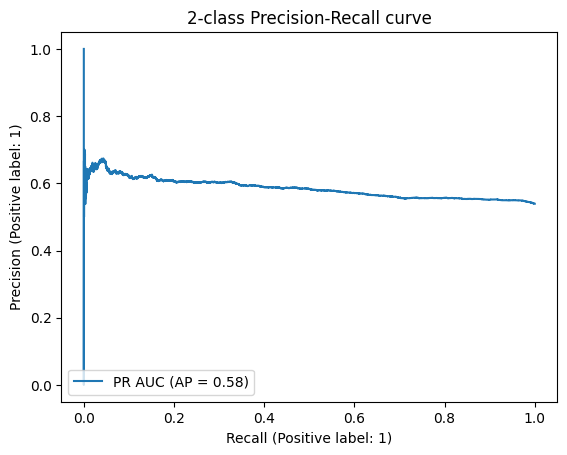

In [29]:
from sklearn.metrics import PrecisionRecallDisplay

if not CFG.optimize and train_test == 'fold':
    disp = PrecisionRecallDisplay.from_predictions(
        y.values, oof, name="PR AUC"
    )
    _ = disp.ax_.set_title("2-class Precision-Recall curve")

# vol 1e6 AP=0.61

### Find the best threshold

ic| bound: 0.3
    prec_score: 0.53939
    obj_num: 7857
    obj_pct: 1.0
    obj_profit: 619
ic| bound: 0.31
    prec_score: 0.54039
    obj_num: 7837
    obj_pct: 0.99
    obj_profit: 633
ic| bound: 0.32
    prec_score: 0.54142
    obj_num: 7811
    obj_pct: 0.99
    obj_profit: 647
ic| bound: 0.33
    prec_score: 0.54228
    obj_num: 7782
    obj_pct: 0.99
    obj_profit: 658
ic| bound: 0.34
    prec_score: 0.54356
    obj_num: 7736
    obj_pct: 0.98
    obj_profit: 674
ic| bound: 0.35
    prec_score: 0.54473
    obj_num: 7679
    obj_pct: 0.97
    obj_profit: 687
ic| bound: 0.36
    prec_score: 0.54653
    obj_num: 7608
    obj_pct: 0.97
    obj_profit: 708
ic| bound: 0.37
    prec_score: 0.54892
    obj_num: 7502
    obj_pct: 0.95
    obj_profit: 734
ic| bound: 0.38
    prec_score: 0.54974
    obj_num: 7369
    obj_pct: 0.94
    obj_profit: 733
ic| bound: 0.39
    prec_score: 0.54953
    obj_num: 7188
    obj_pct: 0.91
    obj_profit: 712
ic| bound: 0.4
    prec_score: 0.55188
   

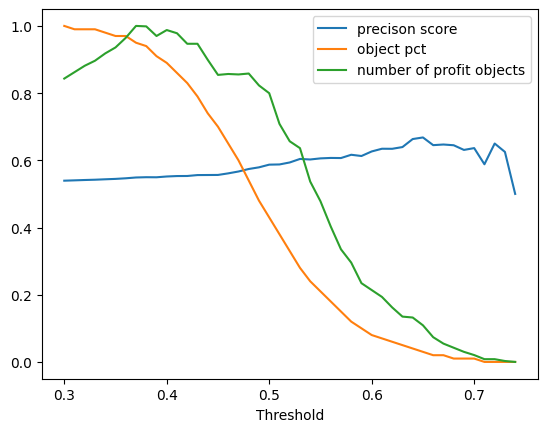

In [30]:
from icecream import ic

if not CFG.optimize and train_test == 'fold':
    prec_score_list = list()
    obj_num_list = list()
    obj_pct_list = list()
    obj_profit_list = list()
    max_obj_profit = 0
    for hb in np.arange(0.3, 0.75, 0.01):
        prec_score, obj_num, obj_pct = confident_score(y.reset_index(drop=True), oof, 1-hb, hb)
        if prec_score == 0:
            obj_num = 0
            obj_pct = 0
        bound, prec_score, obj_num, obj_pct = round(hb, 2), round(prec_score, 5), round(obj_num, 2), round(obj_pct, 2)
        obj_profit = round((2 * prec_score - 1) * obj_num)
        prec_score_list.append(prec_score)
        obj_num_list.append(obj_num)
        obj_pct_list.append(obj_pct)
        obj_profit_list.append(obj_profit)
        max_obj_profit = max(max_obj_profit, obj_profit)
        ic(bound, prec_score, obj_num, obj_pct, obj_profit)

    obj_profit_list = [o / max_obj_profit for o in obj_profit_list]
    line1 = plt.plot(np.arange(0.3, 0.75, 0.01), prec_score_list, label='precison score')
    line2 = plt.plot(np.arange(0.3, 0.75, 0.01), obj_pct_list, label='object pct')
    line3 = plt.plot(np.arange(0.3, 0.75, 0.01), obj_profit_list, label='number of profit objects')
    plt.legend()
    plt.xlabel("Threshold")
    plt.show()

# Compare indicator / signal values for bot and optimizer

In [31]:
# import pandas as pd
# from signals.find_signal import SignalFactory

# ttype = 'buy'
# ticker = 'METHUSDT'
# month = 1
# day = 25
# hour = 6
# configs = ConfigFactory.factory(environ).configs

# x = pd.read_csv(f'../bot/ticker_dataframes/{ticker}_1h_{ttype}_{month}_{day}_{hour}.csv').drop(columns=['Unnamed: 0']).reset_index(drop=True)
# y = pd.read_csv(f'../bot/ticker_dataframes/{ticker}_4h_{ttype}_{month}_{day}_3.csv').drop(columns=['Unnamed: 0']).reset_index(drop=True)

# # add Volume24
# vol24 = indicators.Volume24(ttype, configs)
# x = vol24.get_indicator(x, '', '1h', 0)
# # add Pattern
# pattern = indicators.Pattern(ttype, configs)
# x = pattern.get_indicator(x, '', '', 0)
# # add trend
# trend = indicators.Trend(ttype, configs)
# y = trend.get_indicator(y, '', '', 0)

# # cols = ['time', 'open', 'high', 'low', 'close', 'volume', 'rsi', 'stoch_slowk', 'stoch_slowd', 'linear_reg', 'linear_reg_angle', 'macd', 'macdsignal', 'macdhist']
# cols = ['time', 'open', 'high', 'low', 'close', 'volume', 'linear_reg', 'linear_reg_angle', 'high_max', 'low_min', 'volume_24']

# higher_features = ['time_4h', 'linear_reg', 'linear_reg_angle', 'macd', 'macdhist',  'macd_dir', 
#                    'macdsignal', 'macdsignal_dir']
# y['time_4h'] = y['time'] + pd.to_timedelta(3, unit='h')
# x[['time'] + higher_features] = pd.merge(x[['time']], y[higher_features], how='left', left_on='time', right_on='time_4h')

# x.drop(columns=['time_4h'], inplace=True)
# y.drop(columns=['time_4h'], inplace=True)
# x.ffill(inplace=True)
# x.reset_index(drop=True, inplace=True)

# # get Swing pattern
# pattern = SignalFactory().factory('Pattern', ttype, configs)
# pattern_points = pattern.find_signal(x)
# trend = SignalFactory().factory('Trend', ttype, configs)
# trend_points = trend.find_signal(x)
# idxs = np.where((pattern_points > 0) & (trend_points > 0))
# display(x.loc[idxs[0], cols])

# z = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
# v = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_4h.pkl')

# # add Volume24
# vol24 = indicators.Volume24(ttype, configs)
# z = vol24.get_indicator(z, '', '1h', 0)
# # add Pattern
# pattern = indicators.Pattern(ttype, configs)
# z = pattern.get_indicator(z, '', '', 0)
# # add Trend
# trend = indicators.Trend(ttype, configs)
# v = trend.get_indicator(v, '', '', 0)
# z.tail(48)

# v['time_4h'] = v['time'] + pd.to_timedelta(3, unit='h')
# z[['time'] + higher_features] = pd.merge(z[['time']], y[higher_features], how='left', left_on='time', right_on='time_4h')

# z.drop(columns=['time_4h'], inplace=True)
# v.drop(columns=['time_4h'], inplace=True)
# z.ffill(inplace=True)
# z.reset_index(drop=True, inplace=True)

# # get Swing pattern
# pattern = SignalFactory().factory('Pattern', ttype, configs)
# pattern_points = pattern.find_signal(z)
# trend = SignalFactory().factory('Trend', ttype, configs)
# trend_points = trend.find_signal(z)
# idxs = np.where((pattern_points > 0) & (trend_points > 0))
# display(z.loc[idxs[0], cols][-1:])